# Lab 4 - Working with 'real' data

## William Olsen, partners with Jennifer Vo

In this lab we are going to work on how to estimate the background from 'real' data. Real is in air quotes because the data is actually from simplified simulations to make the problems manageable in a single lab. But the data will have some features that resemble that of real data sets.

In [1]:
# general imports
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import h5py

# this sets the size of the plot to something useful
plt.rcParams["figure.figsize"] = (20,15)

## Problem 1

Lets consider data from a gamma-ray satellite orbiting in low Earth orbit. This satellite records the number of particles detected every 100 milliseconds, with an orbit of approximately 90 minutes. While it is looking for gamma-ray bursts, virtually all of the particles detected are background cosmic rays.

### Part 1

First we will download and explore the data set.  The data has 25 million rows and 4 columns.  The columns are time (in gps seconds), Solar phase (deg) showing the position of the sun relative to the orbit, Earth longitude (deg) giving the position of the spacecraft relative to the ground, and particle counts.

Lets begin by plotting our data to gain a better understanding of its dynamics.  Once we have done this we will provide a high-level description of the features seen in the data.  Finally we will consider how we could construct a background pdf provided possible signal contaimination. 

In [2]:
# first lets load our data
hf = h5py.File('gammaray_lab4.h5', 'r')
data = np.array(hf.get('data'))

In [3]:
# lets split the data further into a time array and eveyrthing else
times = data[0,:]
metadata = data[1:,:]

In [4]:
# lets define variable names for our columns
solar_phase_idx = 0
earth_long_idx = 1
num_particles_idx = 2

# lets define a helper function to return us a subset of the data
def get_subset(x, y, column, start, amount):
    return x[start:min(start+amount, len(x))], y[column, start:min(start+amount, len(y[column]))]

# lets define a helper function for quick plotting
def generate_scatter_plot(x, y, ylabel):
    plt.plot(x, y, 'o')
    plt.tick_params(labelsize=24)
    plt.xlabel('Time (GPS seconds)', fontsize=24)
    plt.ylabel(ylabel, fontsize=24)

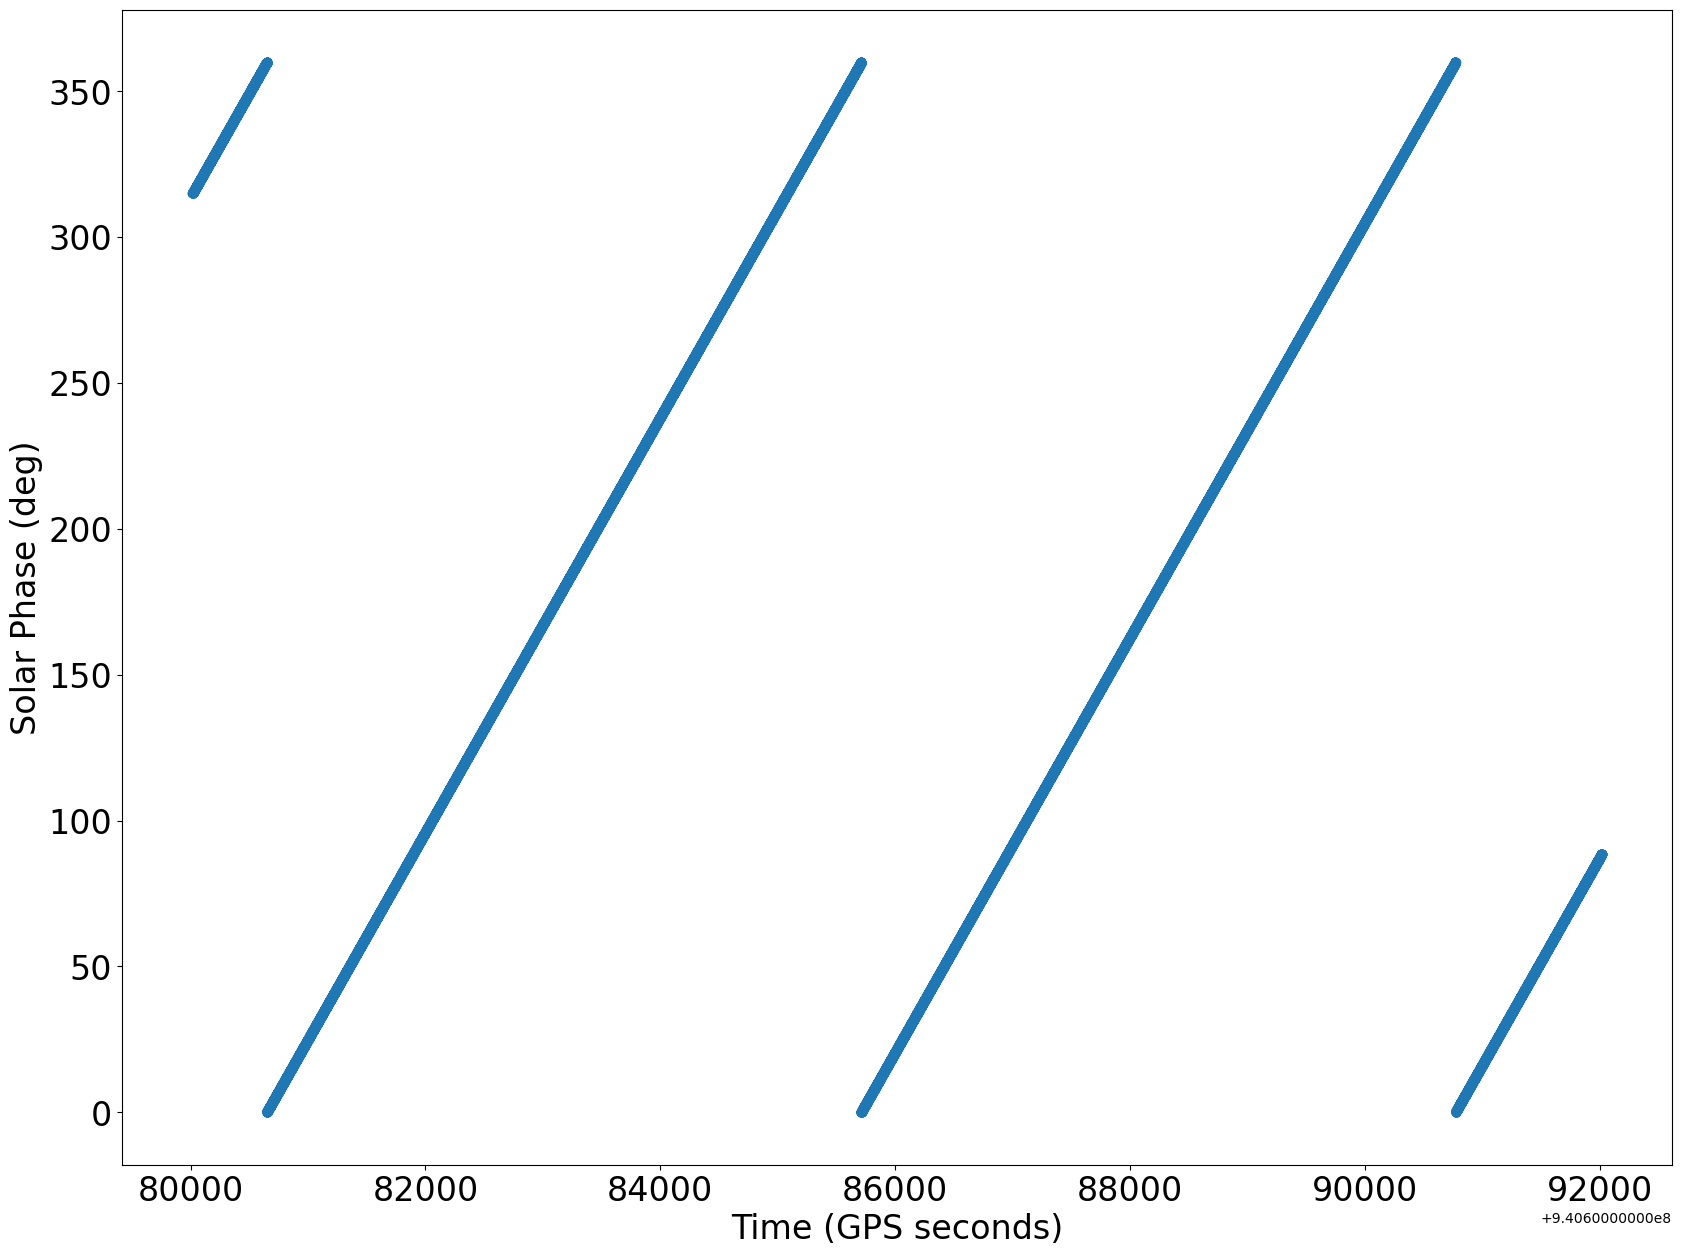

In [5]:
times_sp_1, solar_phase_1 = get_subset(times, metadata, solar_phase_idx, 0, 120000)

generate_scatter_plot(times_sp_1, solar_phase_1, 'Solar Phase (deg)')

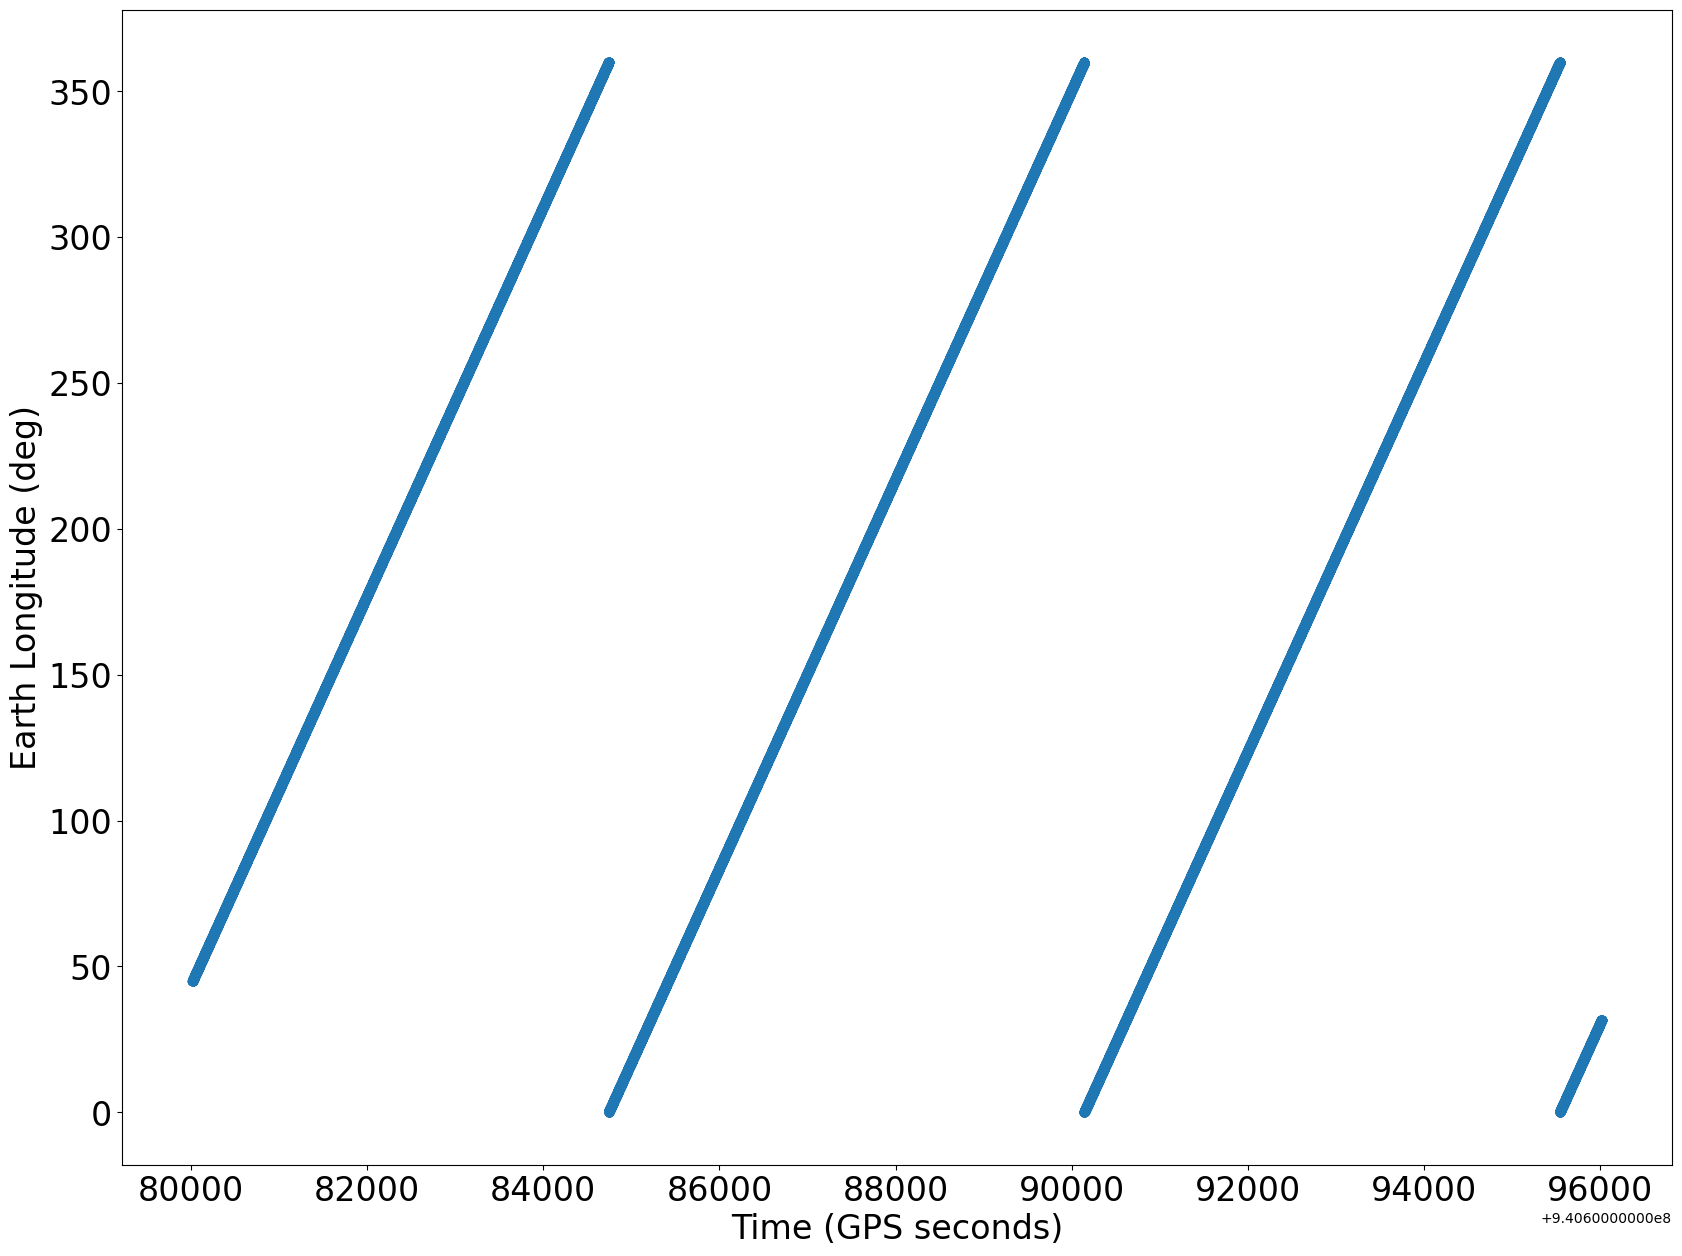

In [6]:
times_el_1, earth_long_1 = get_subset(times, metadata, earth_long_idx, 0, 160000)

generate_scatter_plot(times_el_1, earth_long_1, 'Earth Longitude (deg)')

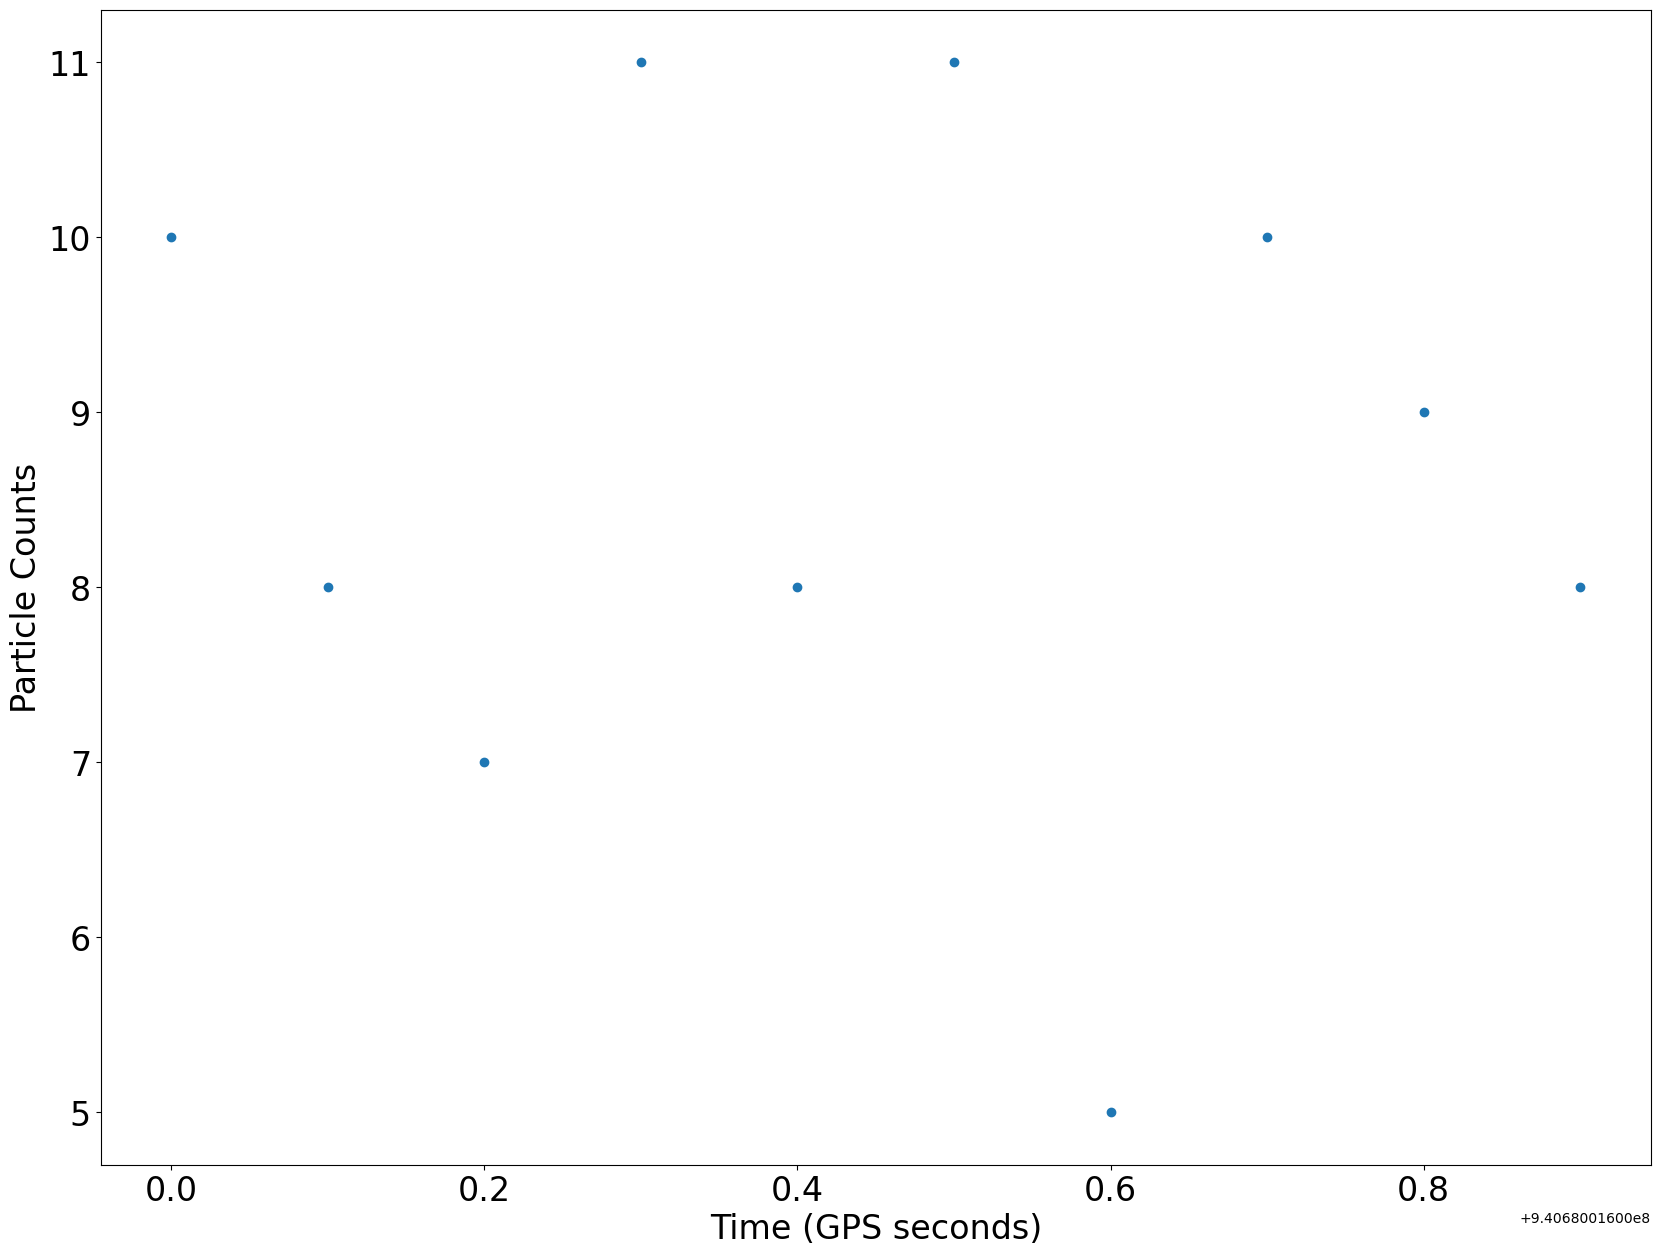

In [7]:
times_pc_1, particle_counts_1 = get_subset(times, metadata, num_particles_idx, 0, 10)

generate_scatter_plot(times_pc_1, particle_counts_1, 'Particle Counts')

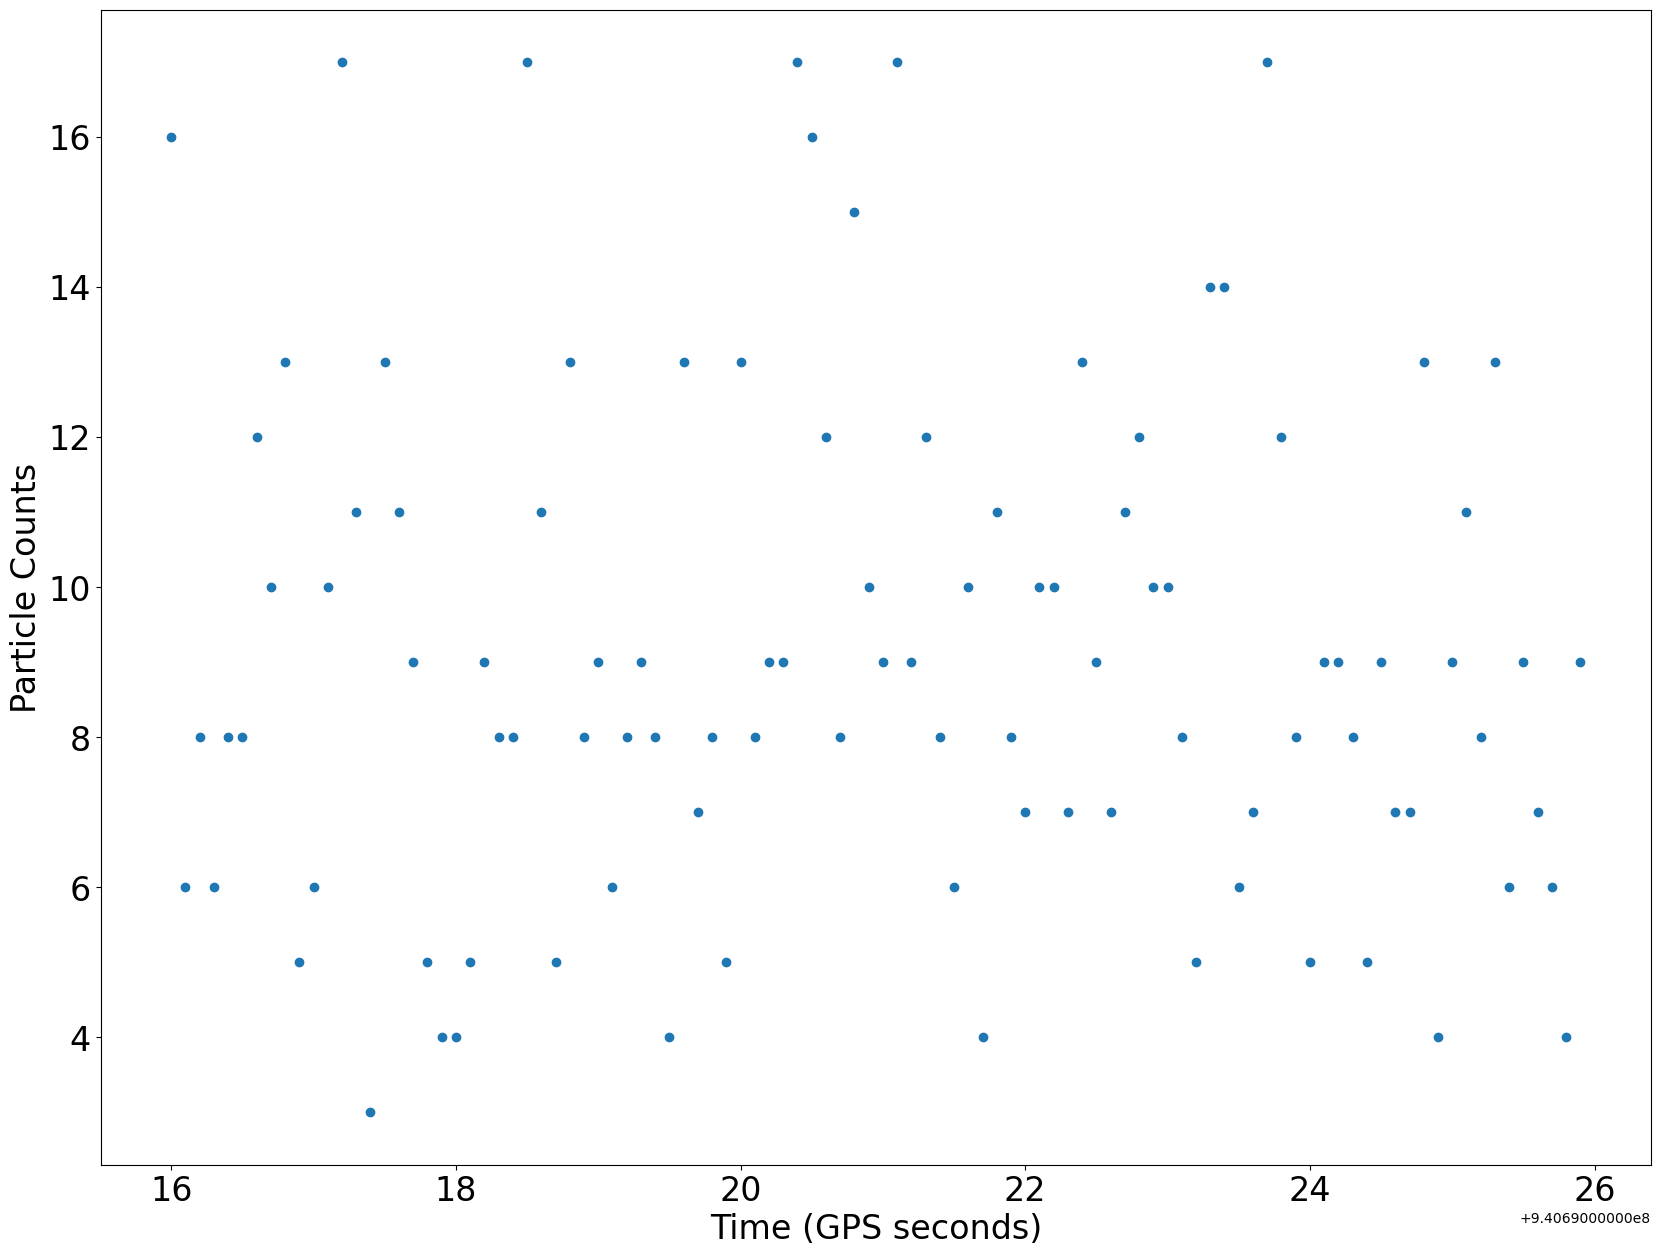

In [8]:
times_pc_2, particle_counts_2 = get_subset(times, metadata, num_particles_idx, 100000, 100)

generate_scatter_plot(times_pc_2, particle_counts_2, 'Particle Counts')

Lets look at the particle counts when we fold the time over a period of the orbit which is 90 minutes or $90*60=5400$ GPS seconds - which is equivalent to $5400*10=54000$ consecutive data points in our array - by plotting our results on a 2D histogram.

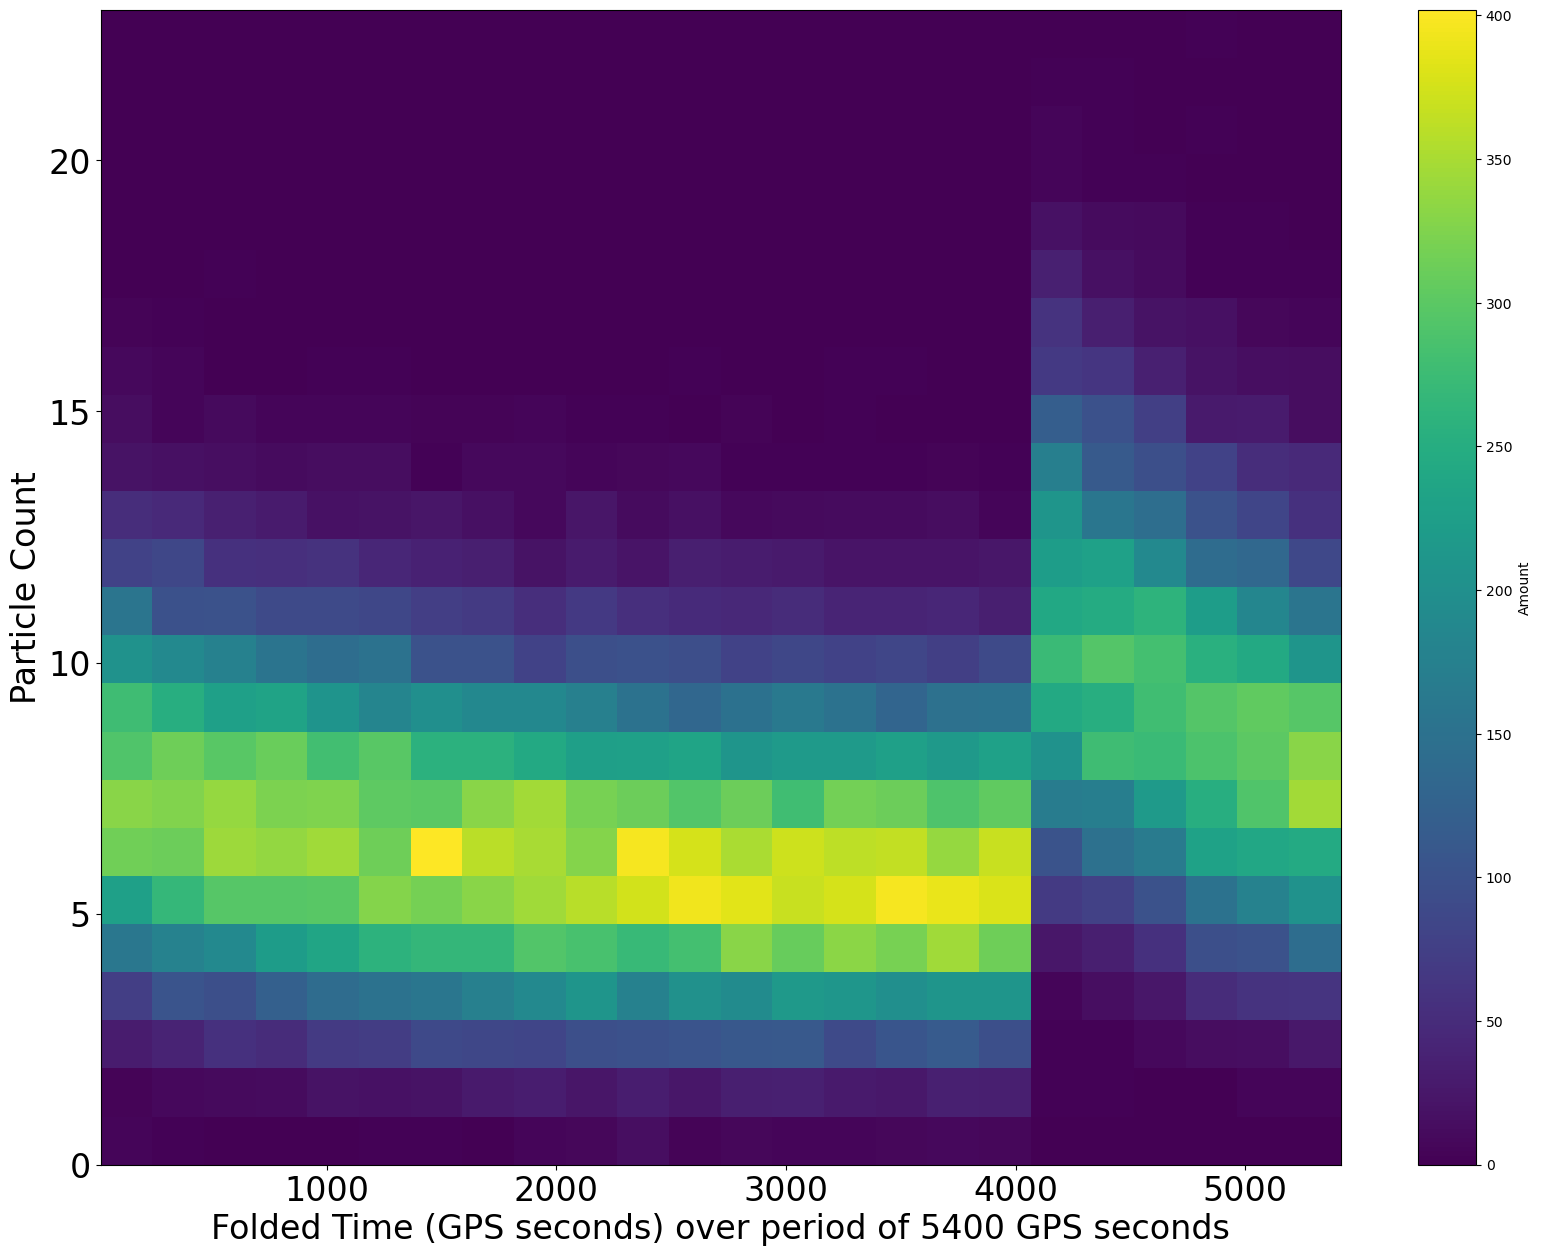

In [9]:
orbit_period = 90*60*10
times_folded = times % orbit_period

times_folded_pc_3, particle_counts_3 = get_subset(times_folded, metadata, num_particles_idx, 0, orbit_period)

fig, ax = plt.subplots(1, 1)

hh = ax.hist2d(times_folded_pc_3, particle_counts_3, bins=24)
plt.tick_params(labelsize=24)
plt.ylim(0, 23)
plt.xlabel('Folded Time (GPS seconds) over period of 5400 GPS seconds', fontsize=24)
plt.ylabel('Particle Count', fontsize=24)

fig.colorbar(hh[3], ax=ax, label='Amount')

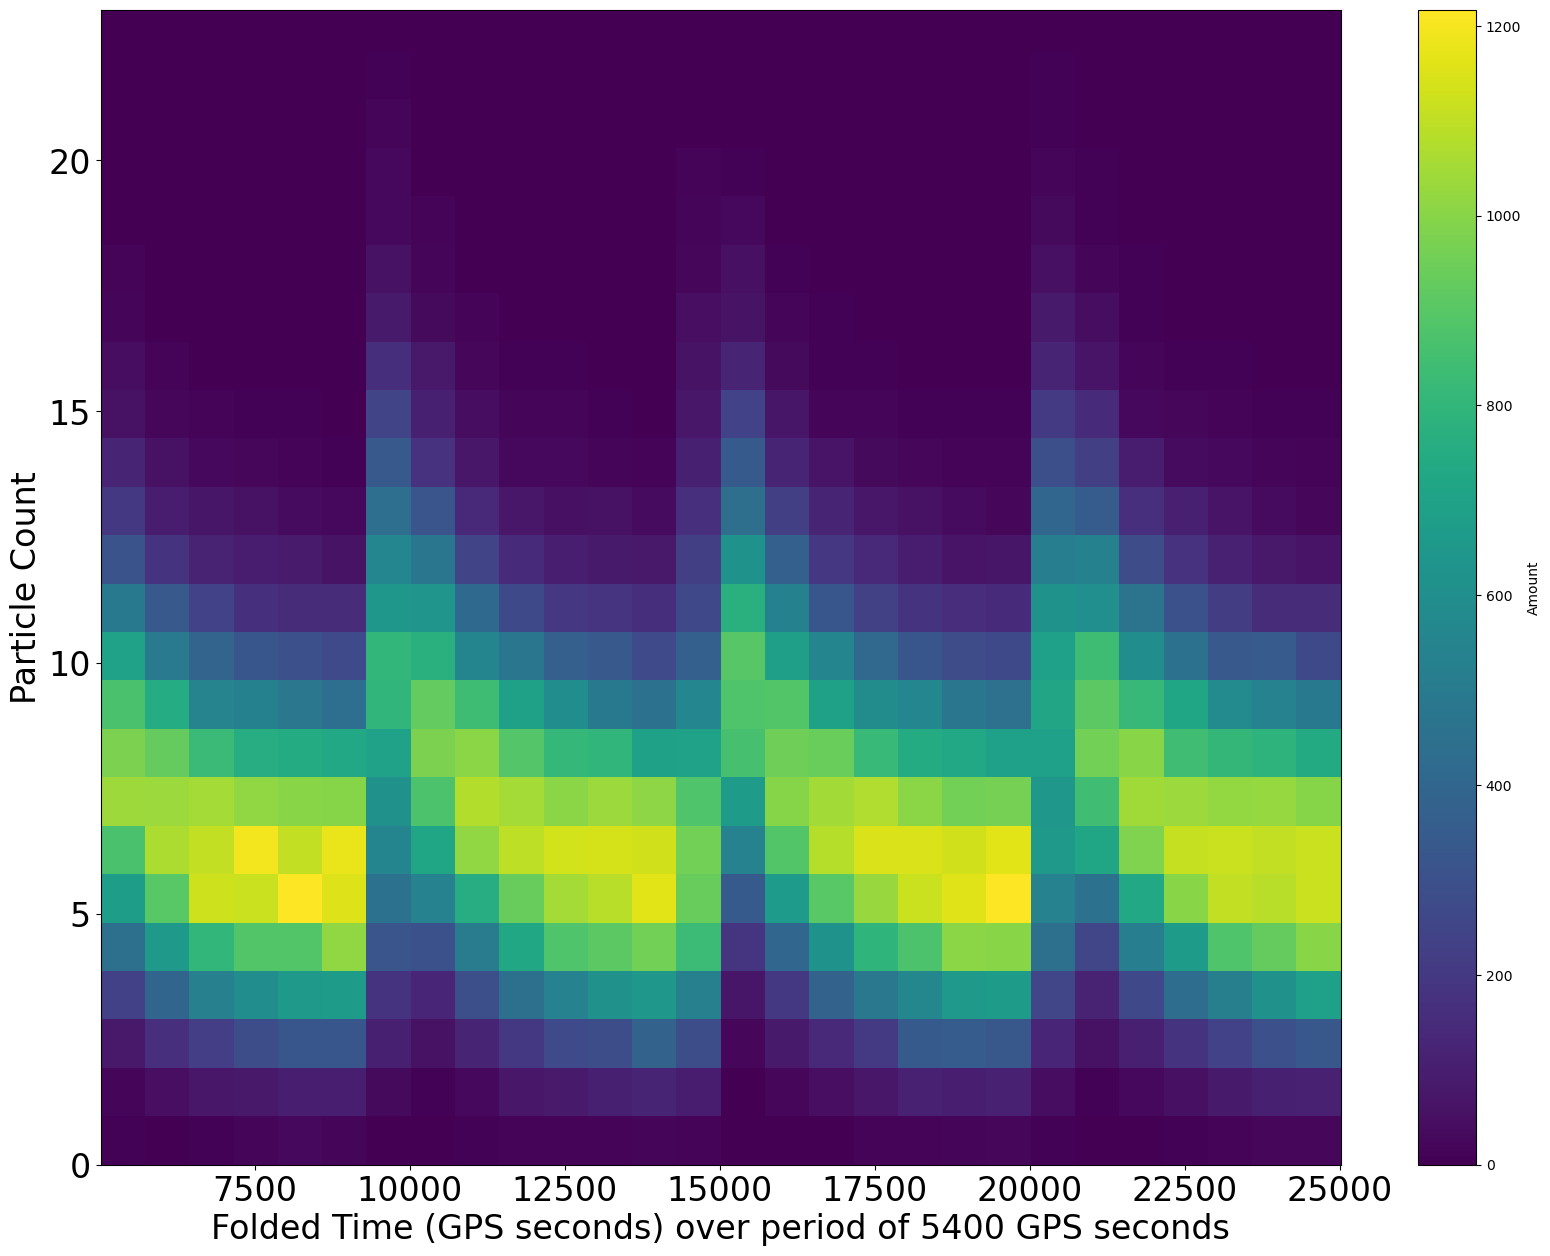

In [10]:
times_folded_pc_4, particle_counts_4 = get_subset(times_folded, metadata, num_particles_idx, 50000, 200000)

fig, ax = plt.subplots(1, 1)

hh = ax.hist2d(times_folded_pc_4, particle_counts_4, bins=28)
plt.tick_params(labelsize=24)
plt.ylim(0, 23)
plt.xlabel('Folded Time (GPS seconds) over period of 5400 GPS seconds', fontsize=24)
plt.ylabel('Particle Count', fontsize=24)

fig.colorbar(hh[3], ax=ax, label='Amount')

From the above plots we can draw many initial conclusions - lets begin with the most obvious ones.  In the first two plots we see that the Solar Phase and the Earth Longitude increase linearly with time then reset back to 0.  This reset is due to both of these values being 'cyclic' and the linear increase is due to the satallite orbiting at - approximately - a constant speed.

Next we will observe the plots regarding the number of particles counted during each 100 millisecond GPS period.  From the first graph of 10 values we see that there is a fluctuation between, on average, around 11 particles at a maximum and 4 at a minimum.  However we do see a large spike in the number of particles that were detected during the period time interval.  Looking over a larger range of times we see that the average still lies between 11 and 4 - however most measurements are around 5 or 7 - and the spikes are a consistent behavior over multiple periods.

To explore this 'spike' further we moved to plot more data over the orbital period and we found that the spike was not eliminated however we do see that as we consider more data a mean reading of around 6 or 7 particles being detected during a GPS second emerges. 

Lets explore this spike further by determining at what point we have the first full solar phase cycle and when we have the first full earth longitudinal cycle.  Once we know these values we will visualize the particle counts during the cycle.

In [11]:
# determine when the first solar phase cycle begins
first_solar_cycle_begin = -1
for i in range(0, len(metadata[solar_phase_idx])):
    if metadata[solar_phase_idx,i] <= 10:
        first_solar_cycle_begin = i
        break
        
# determine when the first earth longitude cycle begins
first_earth_long_begin = -1
for i in range(0, len(metadata[earth_long_idx])):
    if metadata[earth_long_idx,i] <= 10:
        first_earth_long_begin = i
        break

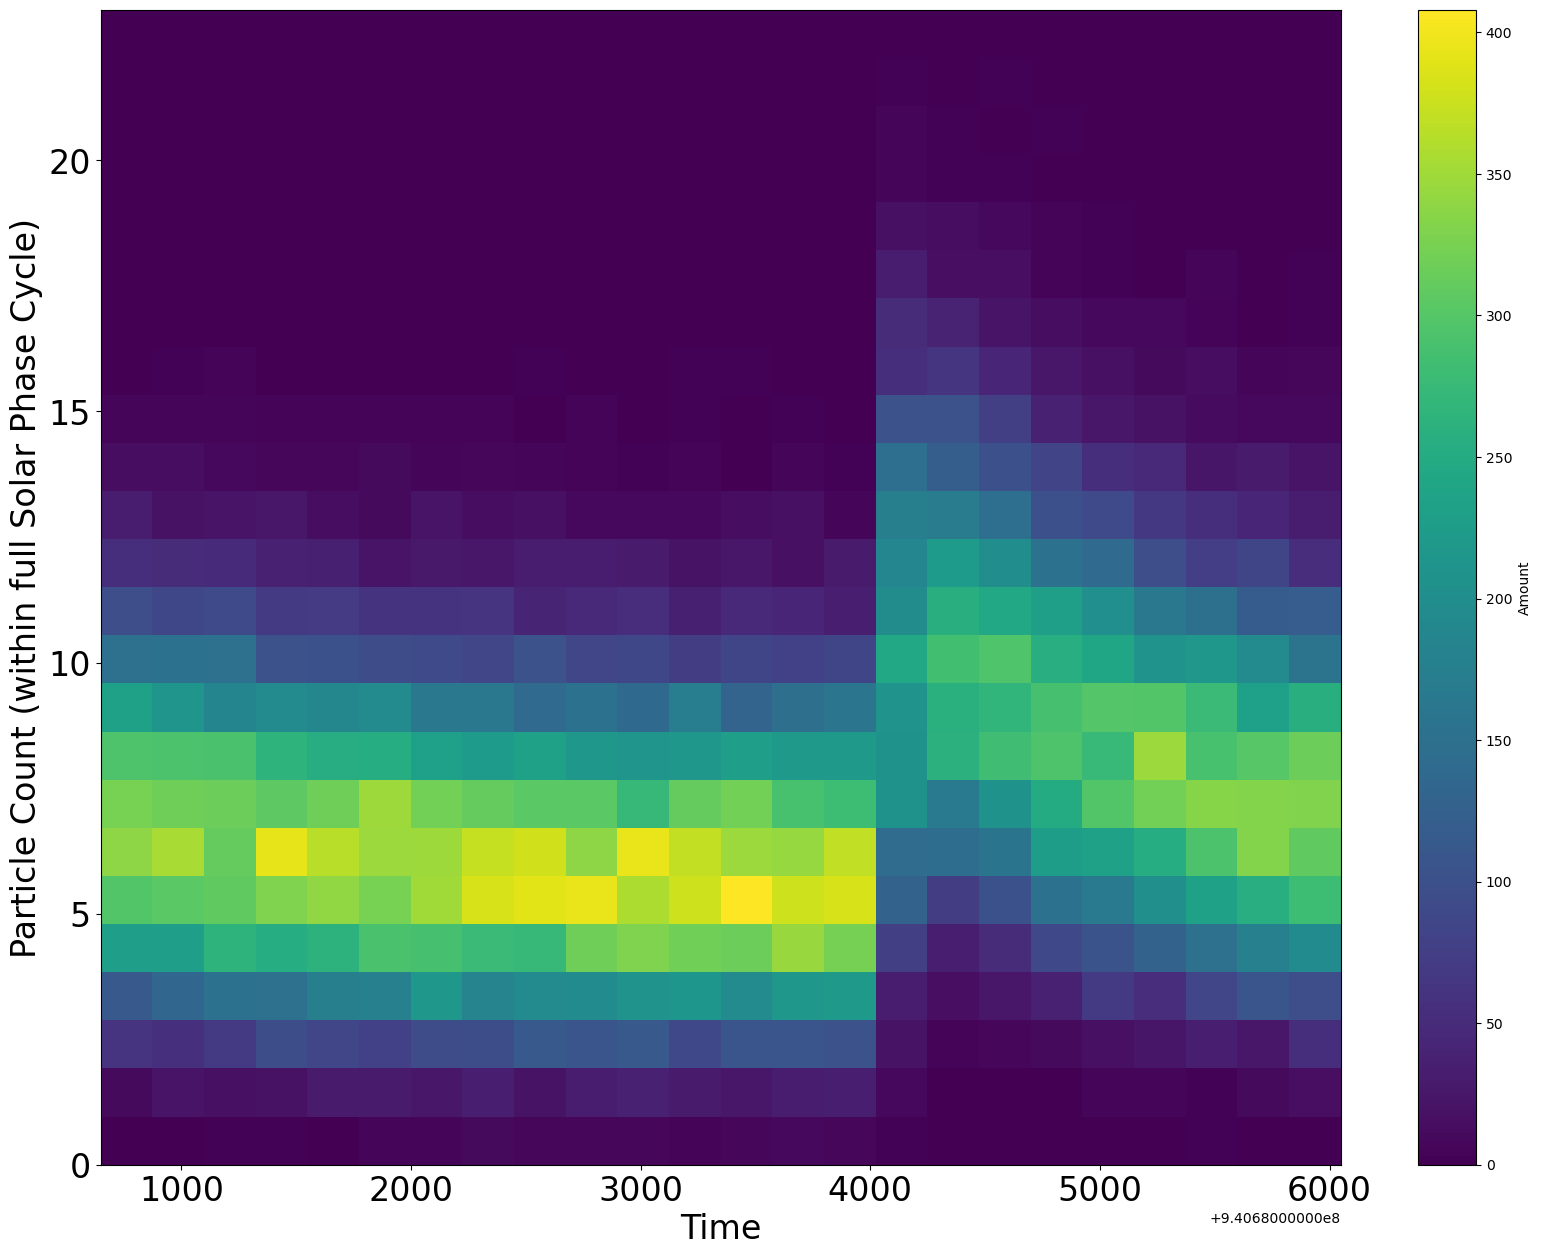

In [12]:
times_sp_cycle_1, num_particles_sp_cycle_1 = get_subset(times, metadata, num_particles_idx, first_solar_cycle_begin, orbit_period)

fig, ax = plt.subplots(1, 1)

hh = ax.hist2d(times_sp_cycle_1, num_particles_sp_cycle_1, bins=24)
plt.tick_params(labelsize=24)
plt.xlabel('Time', fontsize=24)
plt.ylabel('Particle Count (within full Solar Phase Cycle)', fontsize=24)

fig.colorbar(hh[3], ax=ax, label='Amount')

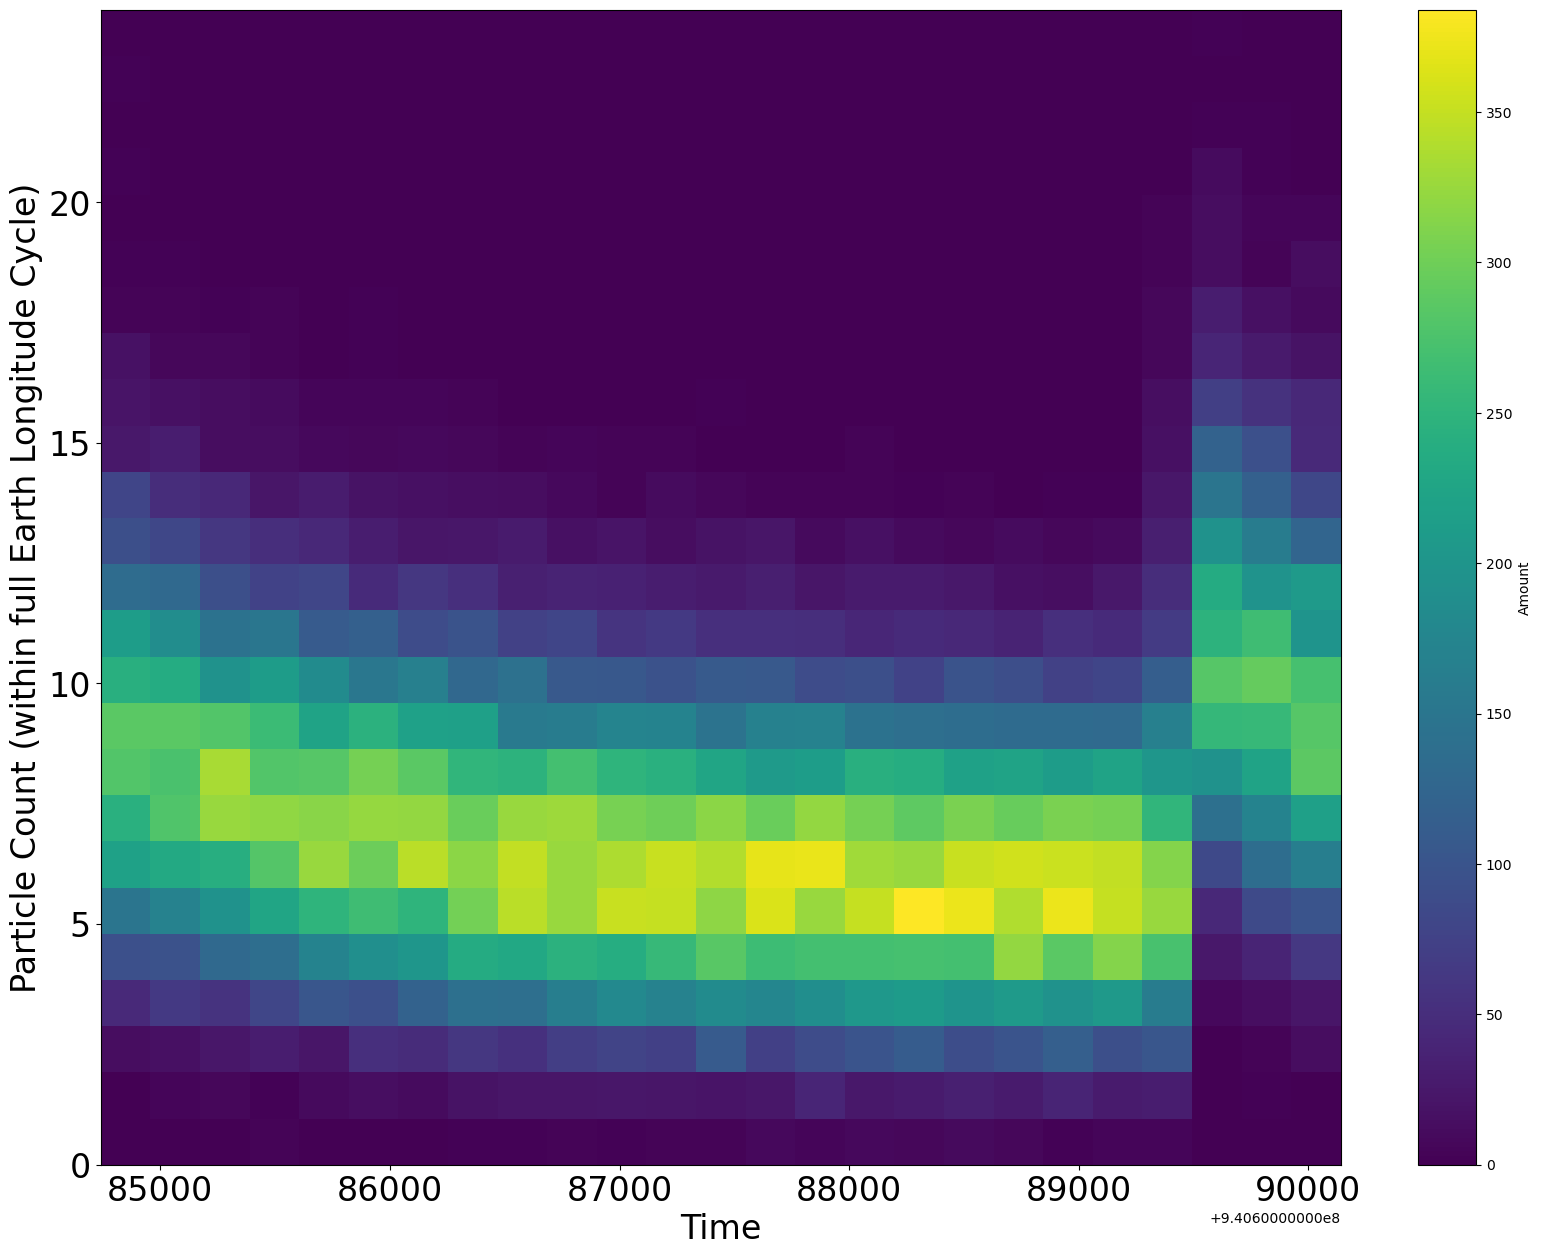

In [13]:
times_el_cycle_1, num_particles_el_cycle_1 = get_subset(times, metadata, num_particles_idx, first_earth_long_begin, orbit_period)

fig, ax = plt.subplots(1, 1)

hh = ax.hist2d(times_el_cycle_1, num_particles_el_cycle_1, bins=25)
plt.tick_params(labelsize=24)
plt.xlabel('Time', fontsize=24)
plt.ylabel('Particle Count (within full Earth Longitude Cycle)', fontsize=24)

fig.colorbar(hh[3], ax=ax, label='Amount')

From the above plots we can draw a few more conclusions.  First of all we see that the spike in the number of particles detected happens once every cycle.  Further more it occurs at a very specific point during the solar cycle and during the earth longitudinal cycle.  Recall that both of these values are in units of degrees thus they vary linearly from 0 to 360 degrees throughout the cucle.  Visually from the above graph we can see the 16th bin (out of 24) is when the spike occurs thus on a linear scale this occurs at a solar phase of about $360 * \frac{16}{24} = 240$ degrees.  Similarly for the plot on the earth longitude cycle we see the spike in bin 23 out of 25 bins thus we see the spike at a value of around $360 * \frac{23}{25} = 331.2$ degrees.


Lets look over more than just one cycle after offsetting forward into the array by some amount of cycles from the initial cycle beginning point:

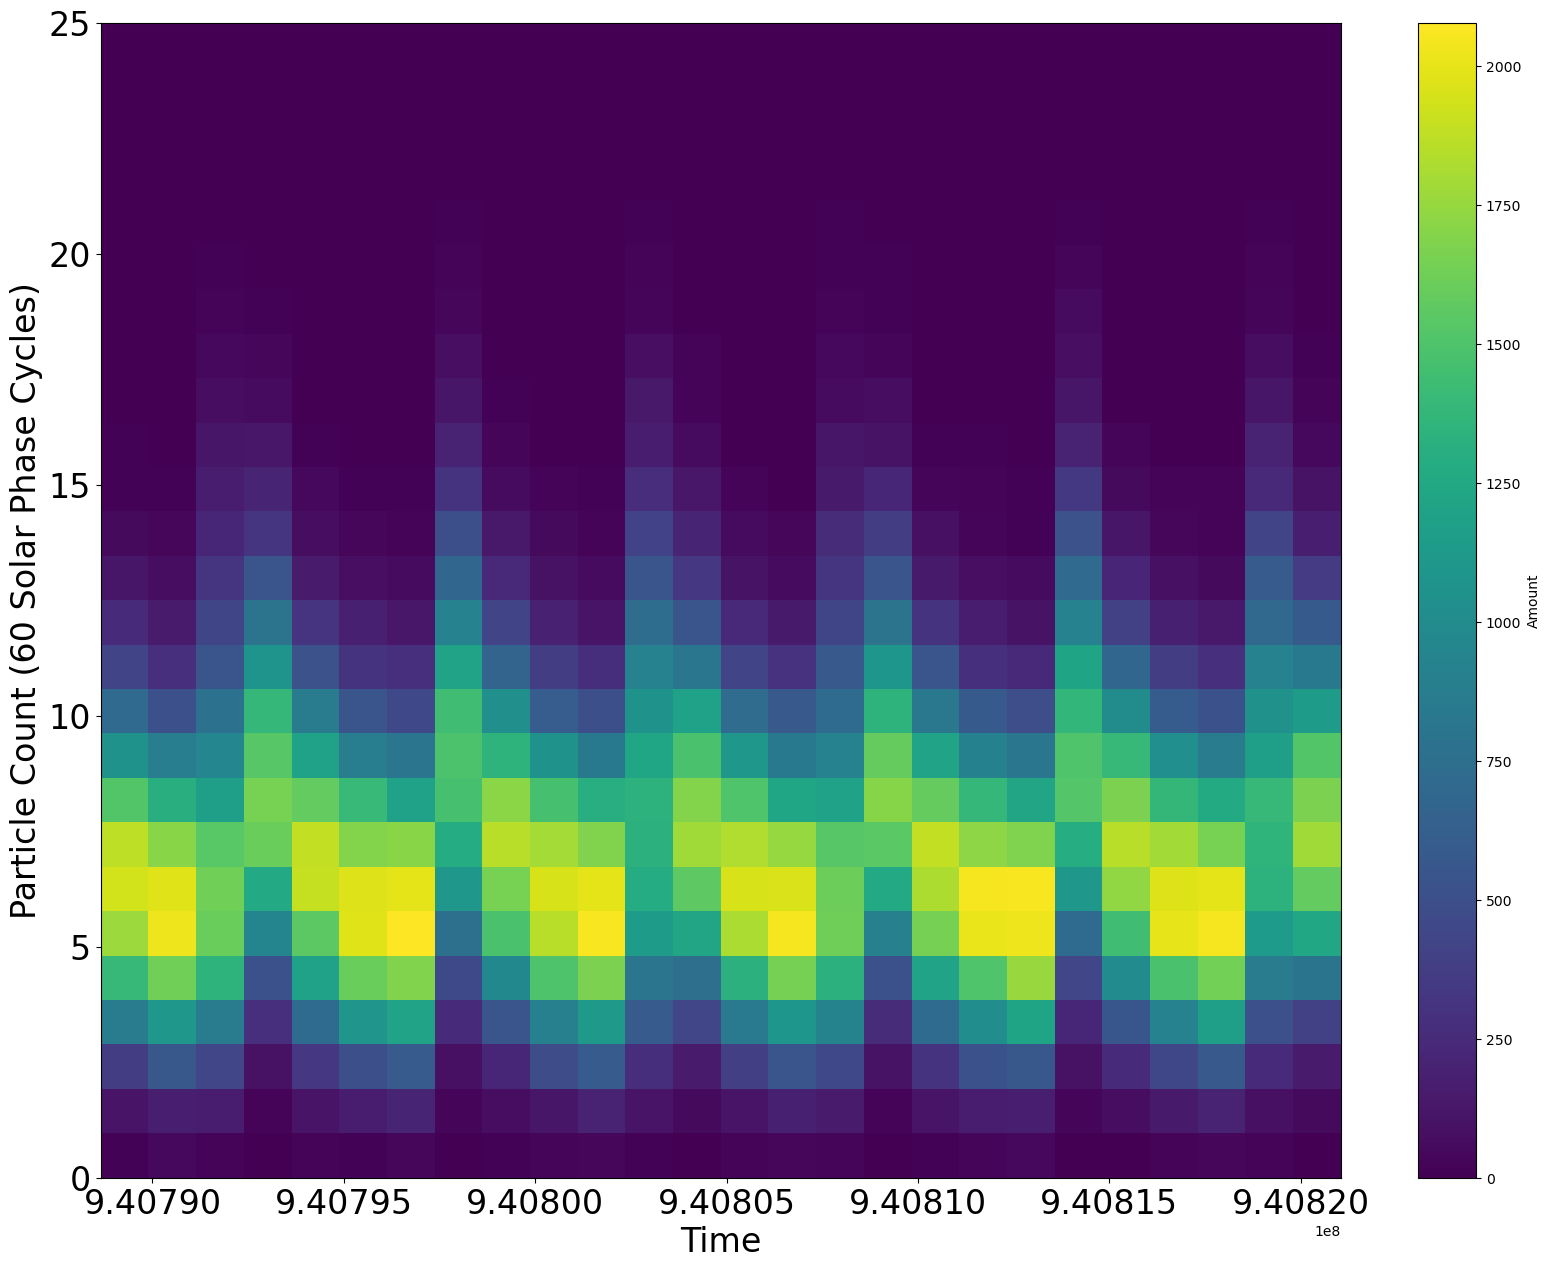

In [14]:
times_sp_cycle_2, num_particles_sp_cycle_2 = get_subset(times, metadata, num_particles_idx, first_solar_cycle_begin + (20*orbit_period), 6*orbit_period)

fig, ax = plt.subplots(1, 1)

hh = ax.hist2d(times_sp_cycle_2, num_particles_sp_cycle_2, bins=26)
plt.tick_params(labelsize=24)
plt.xlabel('Time', fontsize=24)
plt.ylabel('Particle Count (60 Solar Phase Cycles)', fontsize=24)

fig.colorbar(hh[3], ax=ax, label='Amount')

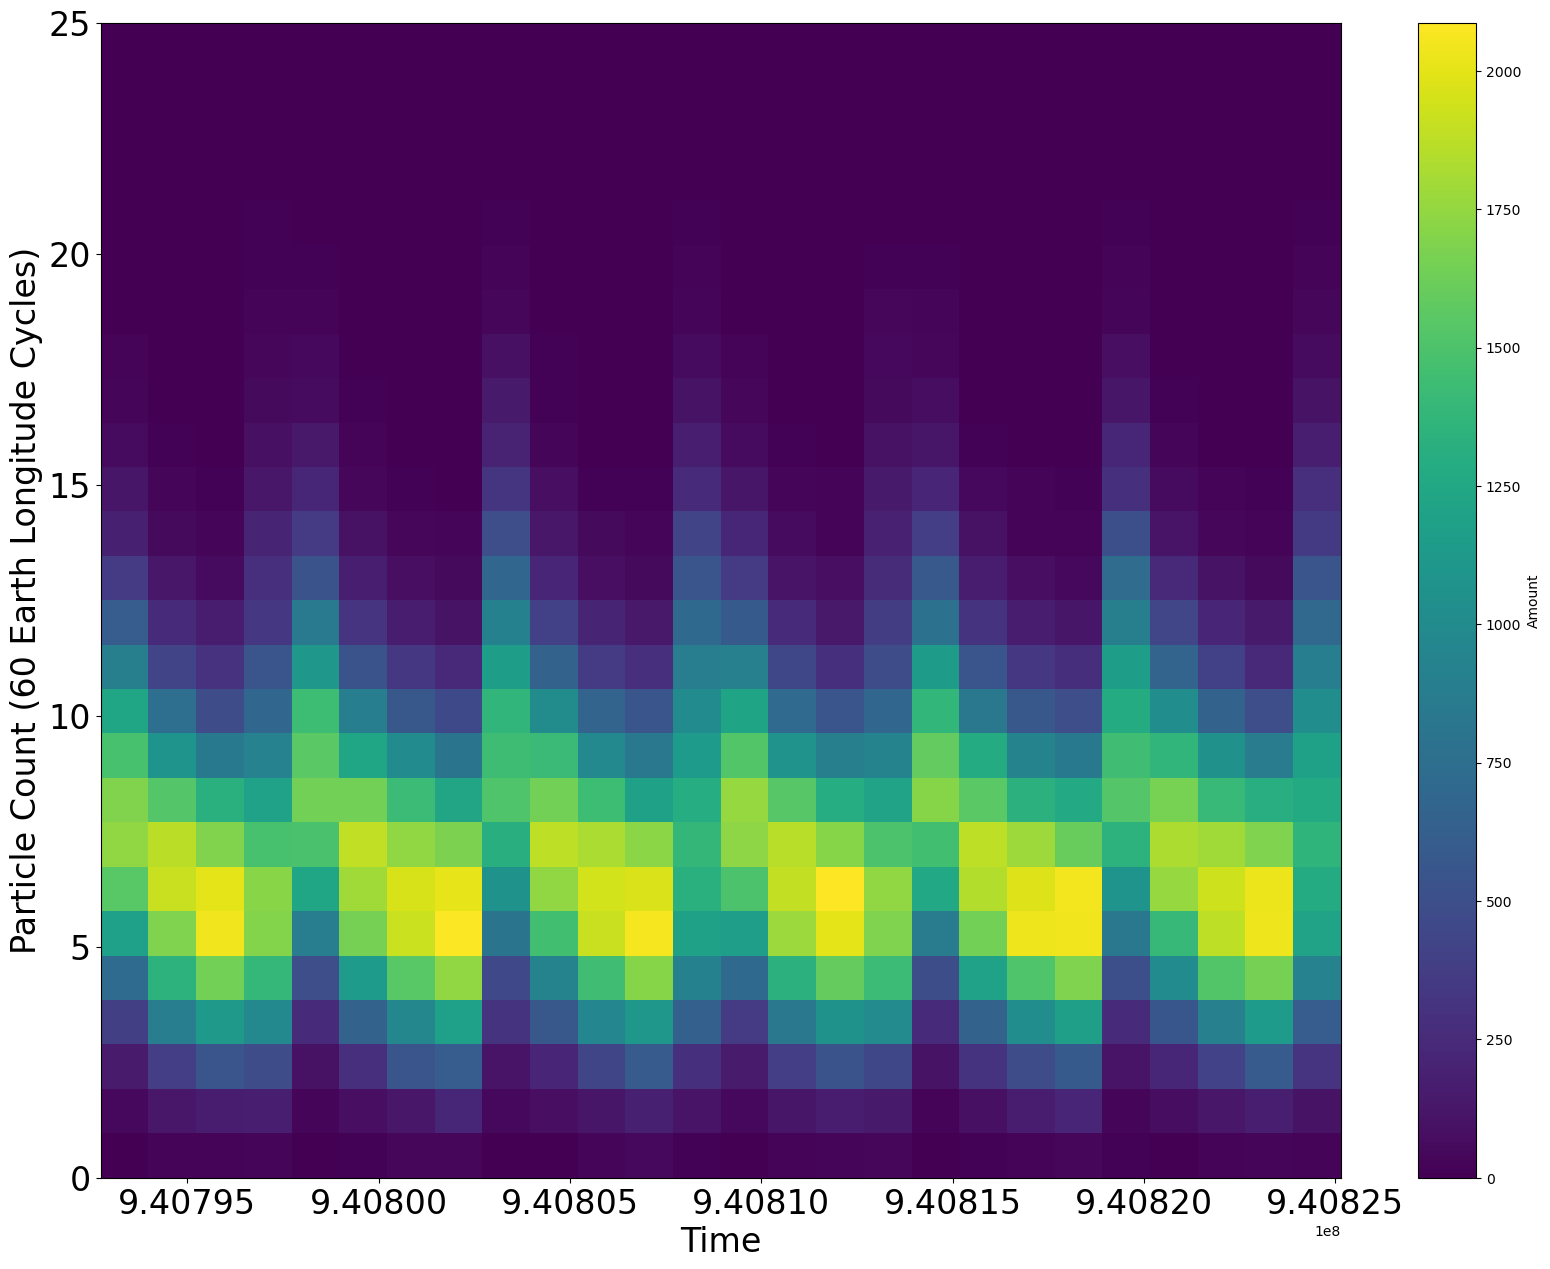

In [15]:
times_el_cycle_2, num_particles_el_cycle_2 = get_subset(times, metadata, num_particles_idx, first_earth_long_begin + (20*orbit_period), 6*orbit_period)

fig, ax = plt.subplots(1, 1)

hh = ax.hist2d(times_el_cycle_2, num_particles_el_cycle_2, bins=26)
plt.tick_params(labelsize=24)
plt.xlabel('Time', fontsize=24)
plt.ylabel('Particle Count (60 Earth Longitude Cycles)', fontsize=24)

fig.colorbar(hh[3], ax=ax, label='Amount')

From the two previous plots we see that we do indeed have a spike every full cycle.  This can be classified as contamination in our data as clearly some outside source is causing our data to have an irregular reading at a regular interval throughout the orbital period.  Lets also recap previuous features noticed to collect our thoughts into one place: we saw that point where the spike occurs is at 240 degrees in the Solar Period and 331.2 degrees Earth Longitude.  We also found a mean value of about 6 or 7 particles being detected per 100ms.  We found that the particle counts flucuate between a minimum of around 3 and a maximum of around 10 expect when we see an irregular spike.  Finally we found that the Solar Phase and Earth Longitude increase linearly then reset back to 0 to begin their increase to 360 again as they are cyclic properties.

From all of this information we can now begin to decide how we would like to construct a background pdf to model our data.  First, because we are looking at particle counts we know that we will want to choose a discrete distribution and we also know that the two most common discrete distributions are the Poisson and Binomial.  The Binomial does not make much sense here because we do not have an item that has a probability of success or probability of failure - rather we are interested in the number of events over a time interval.  This is exactly what the Poisson distribution is focused at modeling.  We also knnow that the cosmic background distribution is Poisson so the conclusion that Poisson would be a strong canidate for our PDF here is not suprising.  Another thing that we would like our Poisson to capture is that the most common values should be 6 or 7 particles detected, followed closely by 5 or 8 particles detected.  This distribution is for the general case.  Provided the spikes our background will follow a different distribution - suggestively a Poisson with the most common value being around 8 particles detected with 7 or 9 detections having the next highest occurance probabilities.

### Part 2

From above we see that the background distribution is **not** constant accross the entirty of the dataset.  Rather the distribution is changing throughout time based on which point we are at during the orbit.  As we discussed previously, because we are counting something we need to use a discrete discribution.  Also we will be using a Poisson distribution because that is the general PDF used when counting cosmic rays.  Now the Poisson distribution only has one parameter that we can change which is $\lambda$.  As our distribution is changing in time we will need our parameter $\lambda$ to be time dependant.  Looking at the plot above it looks like the mean mean value for the number of particles detected has some negative exponential dependance if we define the beginning of a cycle to be right after a spike occurs.


### Part 3

Lets explore constructing a Poisson distribution that has a parameter $\lambda$ that varries in time - specifically varrying with respect to an exponential function.  Above we have a plot of the number of particles detected over a full earth longitude cycle, lets begin with this plot to determine our exact distribution.  This plot is repeated below:

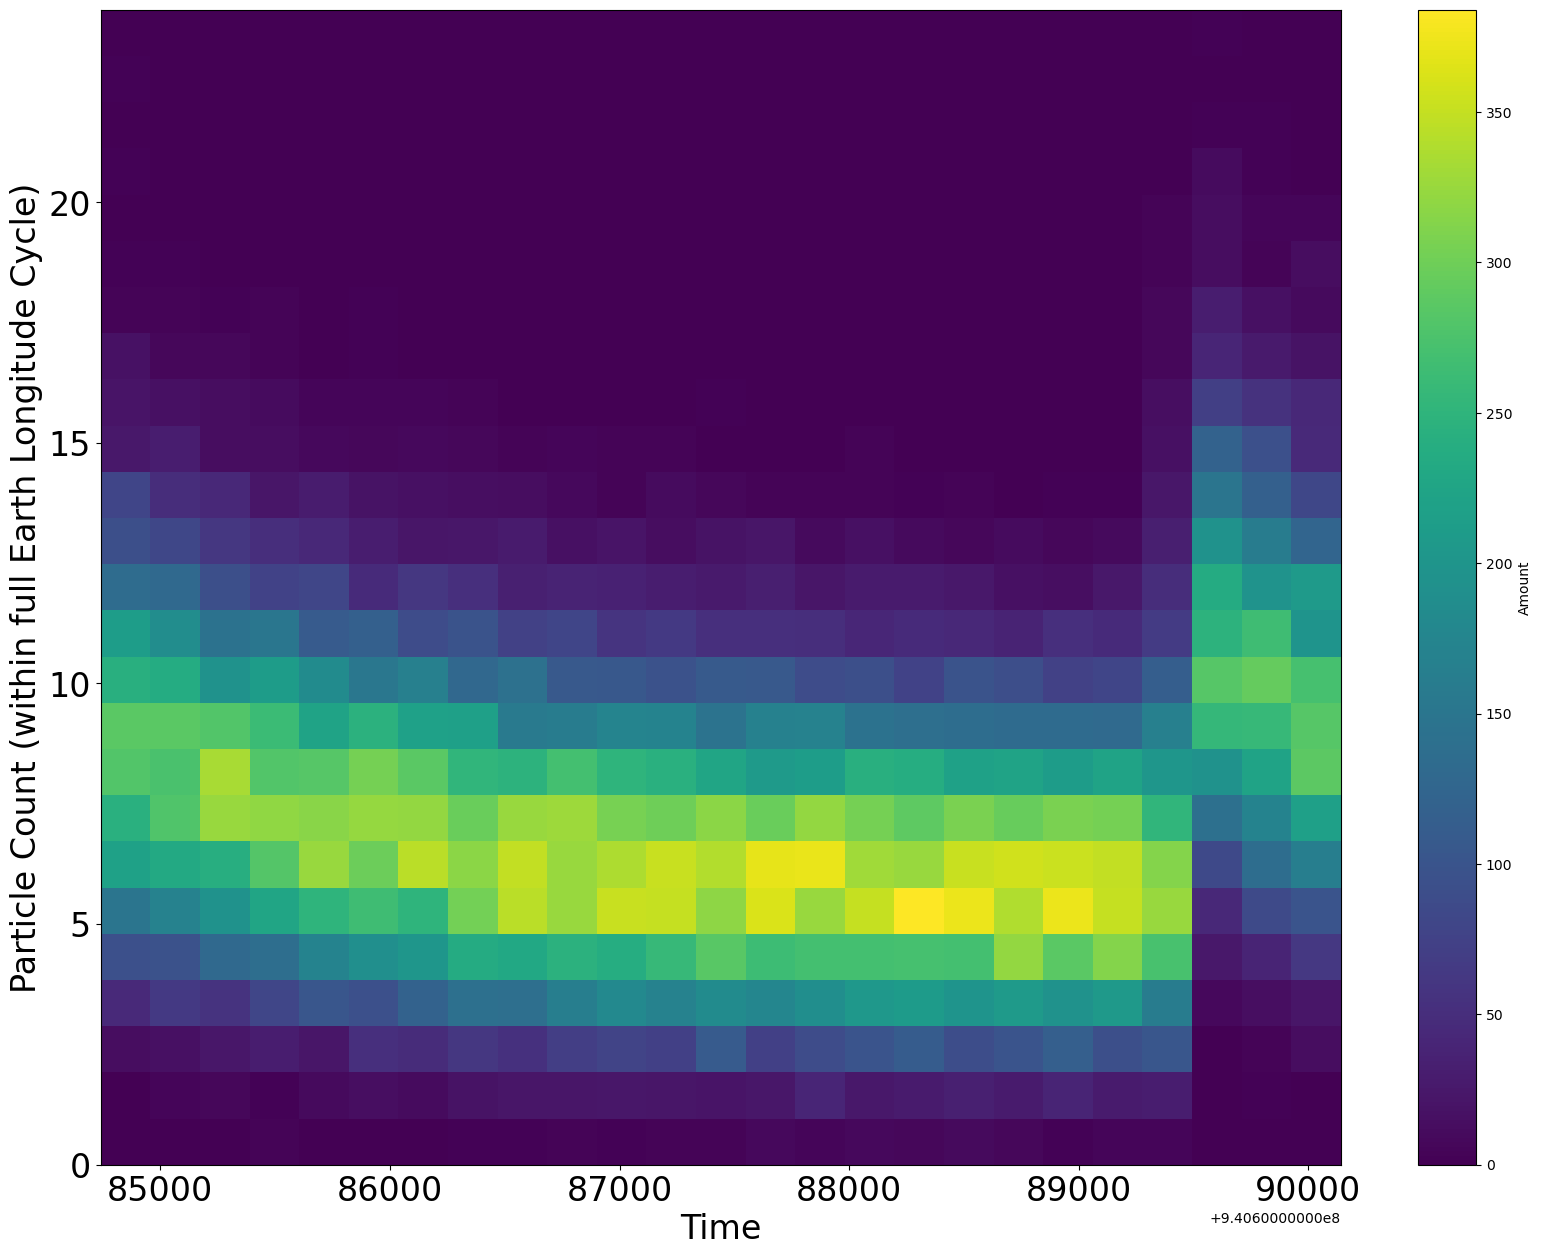

In [16]:
times_el_cycle_1, num_particles_el_cycle_1 = get_subset(times, metadata, num_particles_idx, first_earth_long_begin, orbit_period)

fig, ax = plt.subplots(1, 1)

hh = ax.hist2d(times_el_cycle_1, num_particles_el_cycle_1, bins=25)
plt.tick_params(labelsize=24)
plt.xlabel('Time', fontsize=24)
plt.ylabel('Particle Count (within full Earth Longitude Cycle)', fontsize=24)

fig.colorbar(hh[3], ax=ax, label='Amount')

To determine a more precise time dependance for the parameter $\lambda$ lets observe the the particle counts with respect to the earth longitude over a large number of data points.  Natually this data will be folded as the earth longitude is a periodic parameter:

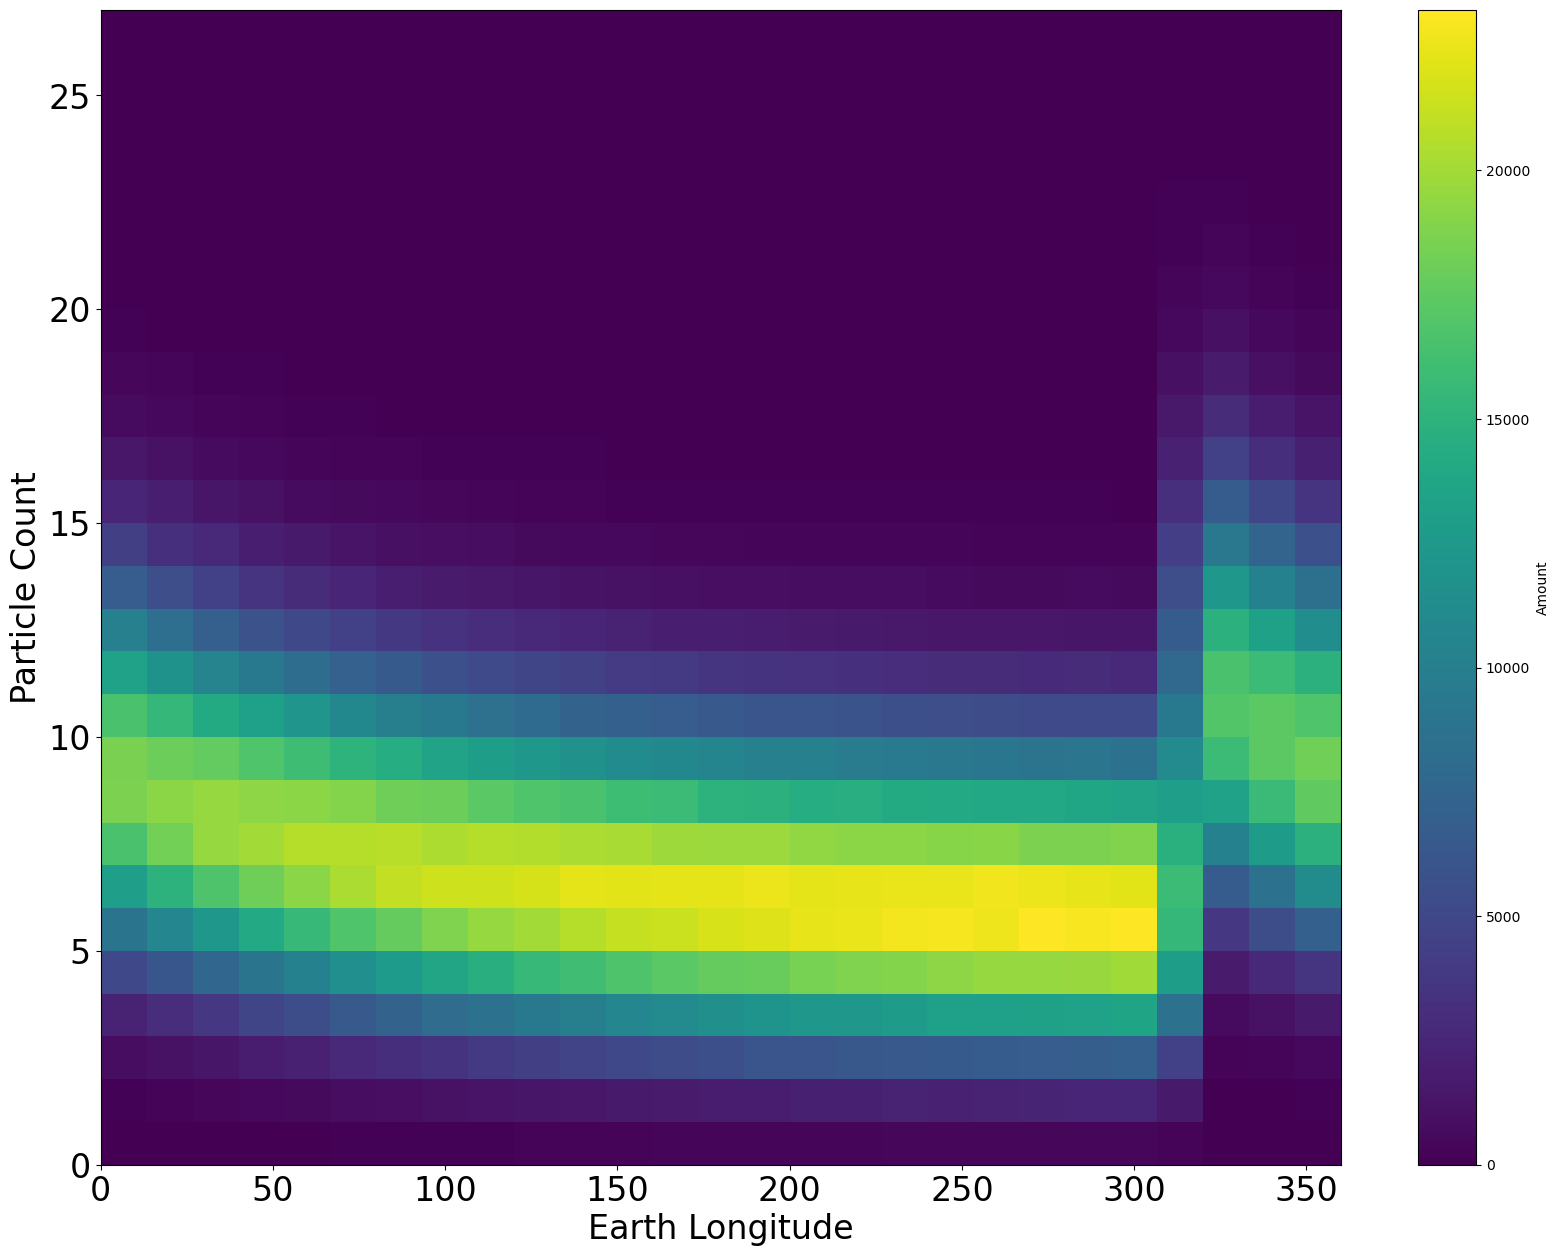

In [17]:
earth_long_cycle_2, num_particles_el_cycle_2 = get_subset(metadata[earth_long_idx,:], metadata, num_particles_idx, 0, 70*orbit_period)

fig, ax = plt.subplots(1, 1)

hh = ax.hist2d(earth_long_cycle_2, num_particles_el_cycle_2, bins=27)
plt.tick_params(labelsize=24)
plt.xlabel('Earth Longitude', fontsize=24)
plt.ylabel('Particle Count', fontsize=24)

fig.colorbar(hh[3], ax=ax, label='Amount')

We see that the cycle begins to repeat when the earth longitude is equal to around $325$ degrees.  Tinkering with this exact value we find that the cycle truely repeats when the earth longitude is equal to $314$ degrees.  Let's plot the phase shifted graph:

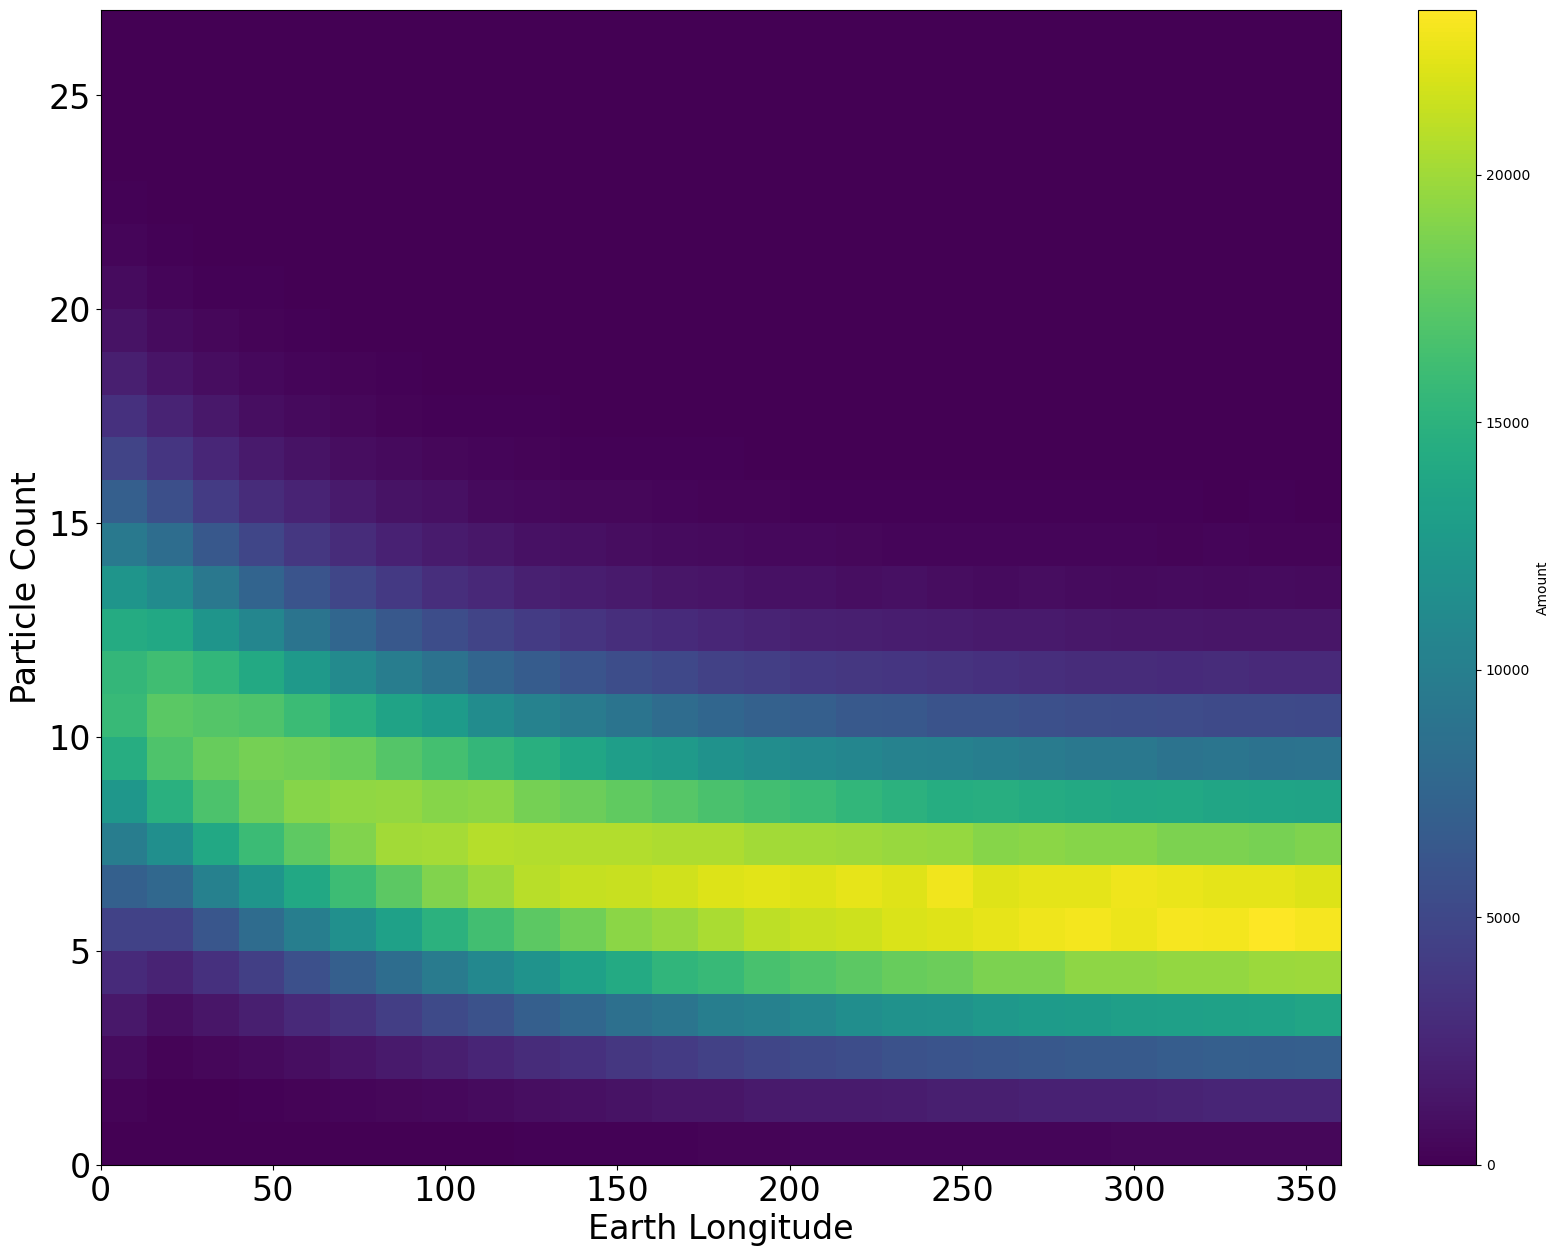

In [64]:
earth_long_cycle_repeat = 314

earth_long_cycle_3, num_particles_el_cycle_3 = get_subset(metadata[earth_long_idx,:], metadata, num_particles_idx, 0, 70*orbit_period)

earth_long_cycle_3 = (earth_long_cycle_3 - earth_long_cycle_repeat) % 360

fig, ax = plt.subplots(1, 1)

hh = ax.hist2d(earth_long_cycle_3, num_particles_el_cycle_3, bins=27)
plt.tick_params(labelsize=24)
plt.xlabel('Earth Longitude', fontsize=24)
plt.ylabel('Particle Count', fontsize=24)

fig.colorbar(hh[3], ax=ax, label='Amount')

With this plot lets now tinker and fit an exponential function to our data.  Once we find this exponential function this function will be exactly our parameter of $\lambda$ in terms of the earth longitude - then we will convert to make $\lambda$ a function of time. 

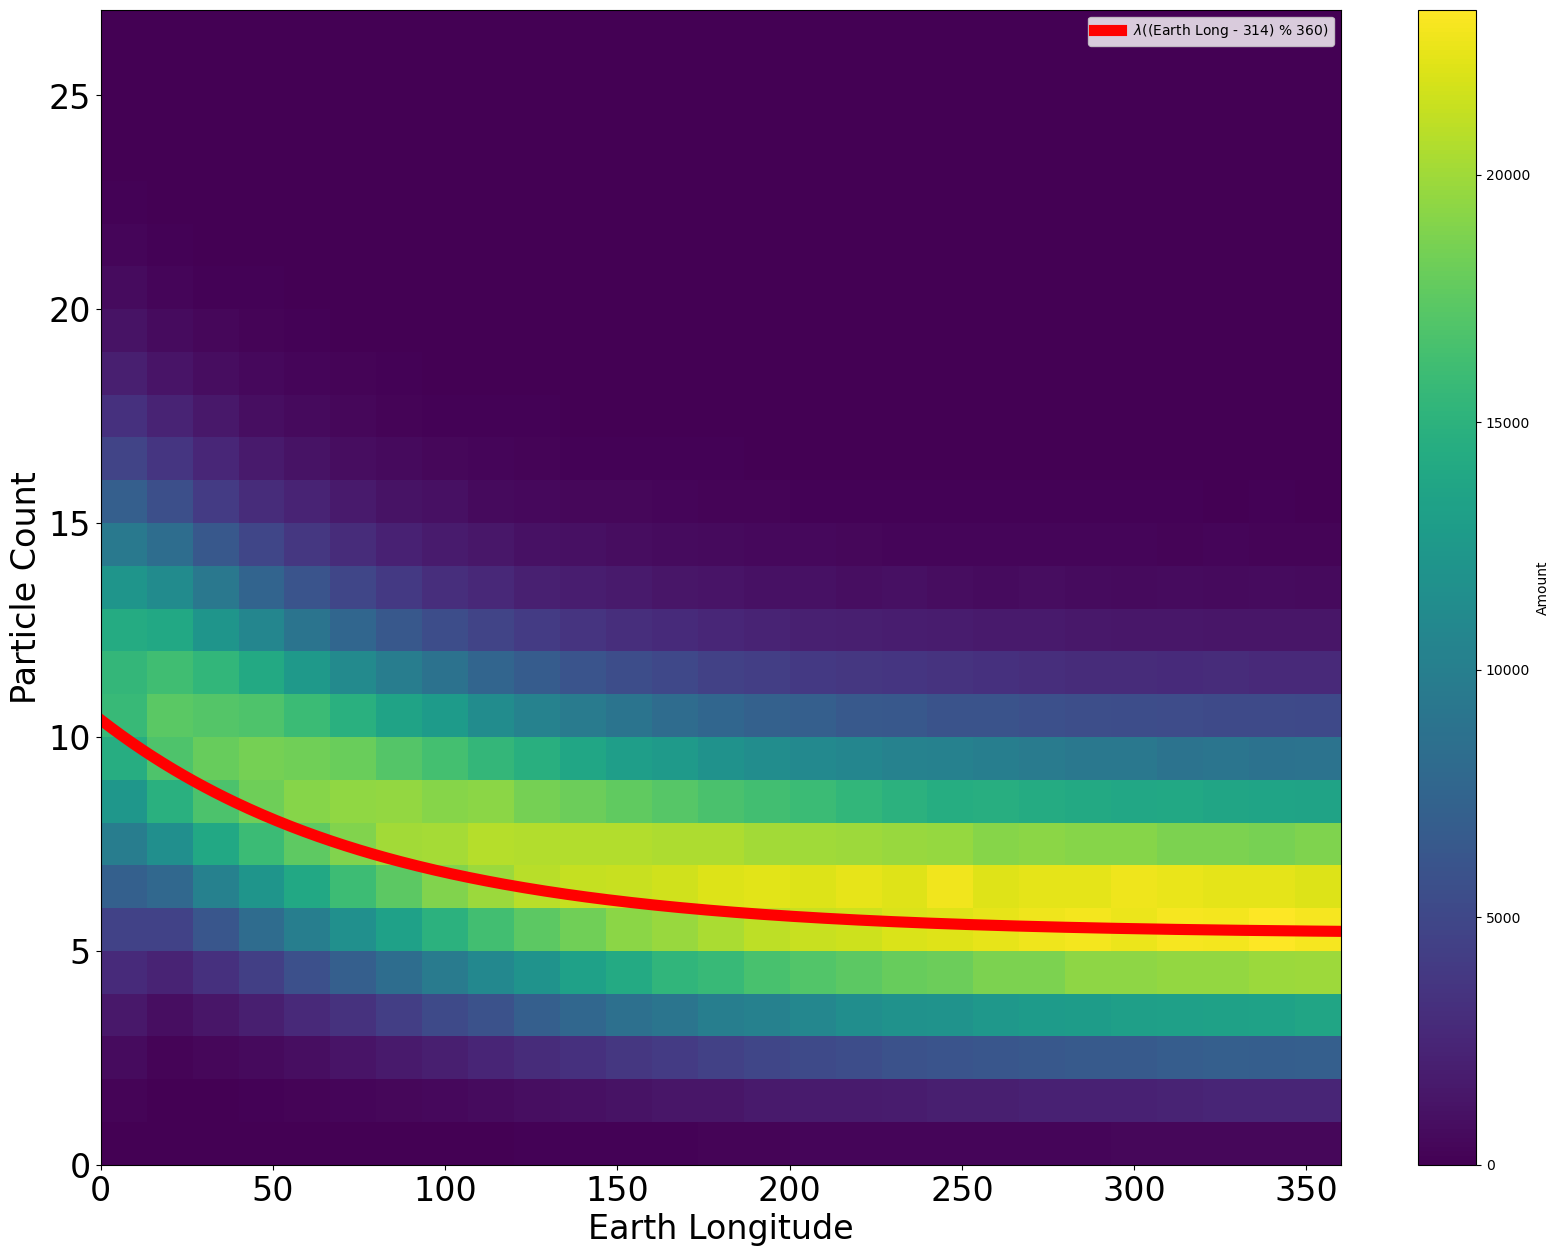

In [74]:
earth_long_cycle_4, num_particles_el_cycle_4 = get_subset(metadata[earth_long_idx,:], metadata, num_particles_idx, 0, 70*orbit_period)

earth_long_cycle_4 = (earth_long_cycle_4 - earth_long_cycle_repeat) % 360

xs_means = np.linspace(0, 360, 361)
means_exp = 5 * np.power(np.e, -(xs_means)/80) + 5.7

fig, ax = plt.subplots(1, 1)

hh = ax.hist2d(earth_long_cycle_4, num_particles_el_cycle_4, bins=27)
plt.plot(xs_means, means_exp, linewidth=8, color='r', label='$\lambda$((Earth Long - 314) % 360)')
plt.tick_params(labelsize=24)
plt.xlabel('Earth Longitude', fontsize=24)
plt.ylabel('Particle Count', fontsize=24)

fig.colorbar(hh[3], ax=ax, label='Amount')
plt.legend()

Now we have an equation for $\lambda$ in terms of the earth longitude, this equation is the following:

$$\lambda(L) = 5e^{-\frac{(L-314) \% 360}{80}} + 5.7$$

Now that we have our equation in terms of the earth longitude we will now convert it to be in terms of time.  Lets determine what the first time we have and what our value of the earth longitude is at that time:

In [66]:
print(f'First GPS time: {times[0]}')
print(f'First Earth Longitude: {metadata[earth_long_idx,0]}')

First GPS time: 940680016.0
First Earth Longitude: 45.0


Provided the two previous values we can construct an equation to convert from time to earth longitude.  First we will determine the position in the total orbital cycle: $(t - t_{start}) \% T_{orbit}$ where $t_{start}=940680016.0$ GPS seconds and $T_{orbit}=5400$ GPS seconds.

Now that we know where we are in the cycle, we can compute the fractional amount into the cycle we are at: $\frac{(t - t_{start}) \% T_{orbit}}{T_{orbit}}$.

With this fractional amount, we know that this will shift us some amount of degrees forward in the earth longitude cycle from the original amount of $\phi_{start}=45$.  We can compute what the current phase is in the following way: $\phi_{start} + 360 *\frac{(t - t_{start}) \% T_{orbit}}{T_{orbit}}$.

Now we can threshold this value to be in the range of 0 to 360 degrees: $(\phi_{start} + 360 *\frac{(t - t_{start}) \% T_{orbit}}{T_{orbit}}) \% 360$.

Now we have converted our background distributions parameter to be a function of time instead of earth longitude:

$$\lambda(t) = 5e^{-\frac{\bigg(\phi_{start} + 360 *\frac{\big(t - t_{start}\big) \% T_{orbit}}{T_{orbit}}\bigg) \% 360}{80}} + 5.7$$

Once again where $t_{start}=940680016.0$ GPS seconds, $\phi_{start} = 45$ degrees, and $T_{orbit}=5400$ GPS seconds.

Let's visualize our distribution parameter over a long period of time:

In [81]:
# lets define a function for our distribution
def cosmic_pdf_lambda(times):
    t_start = 940680016.0
    phi_start = 45
    T_orbit = 5400
    
    cycle_fraction = ((times - t_start) % T_orbit) / T_orbit
    
    longitude = (phi_start + (360 * cycle_fraction)) % 360
    
    lambdas = 5 * np.power(np.e, -(longitude)/80) + 5.7
    
    return lambdas

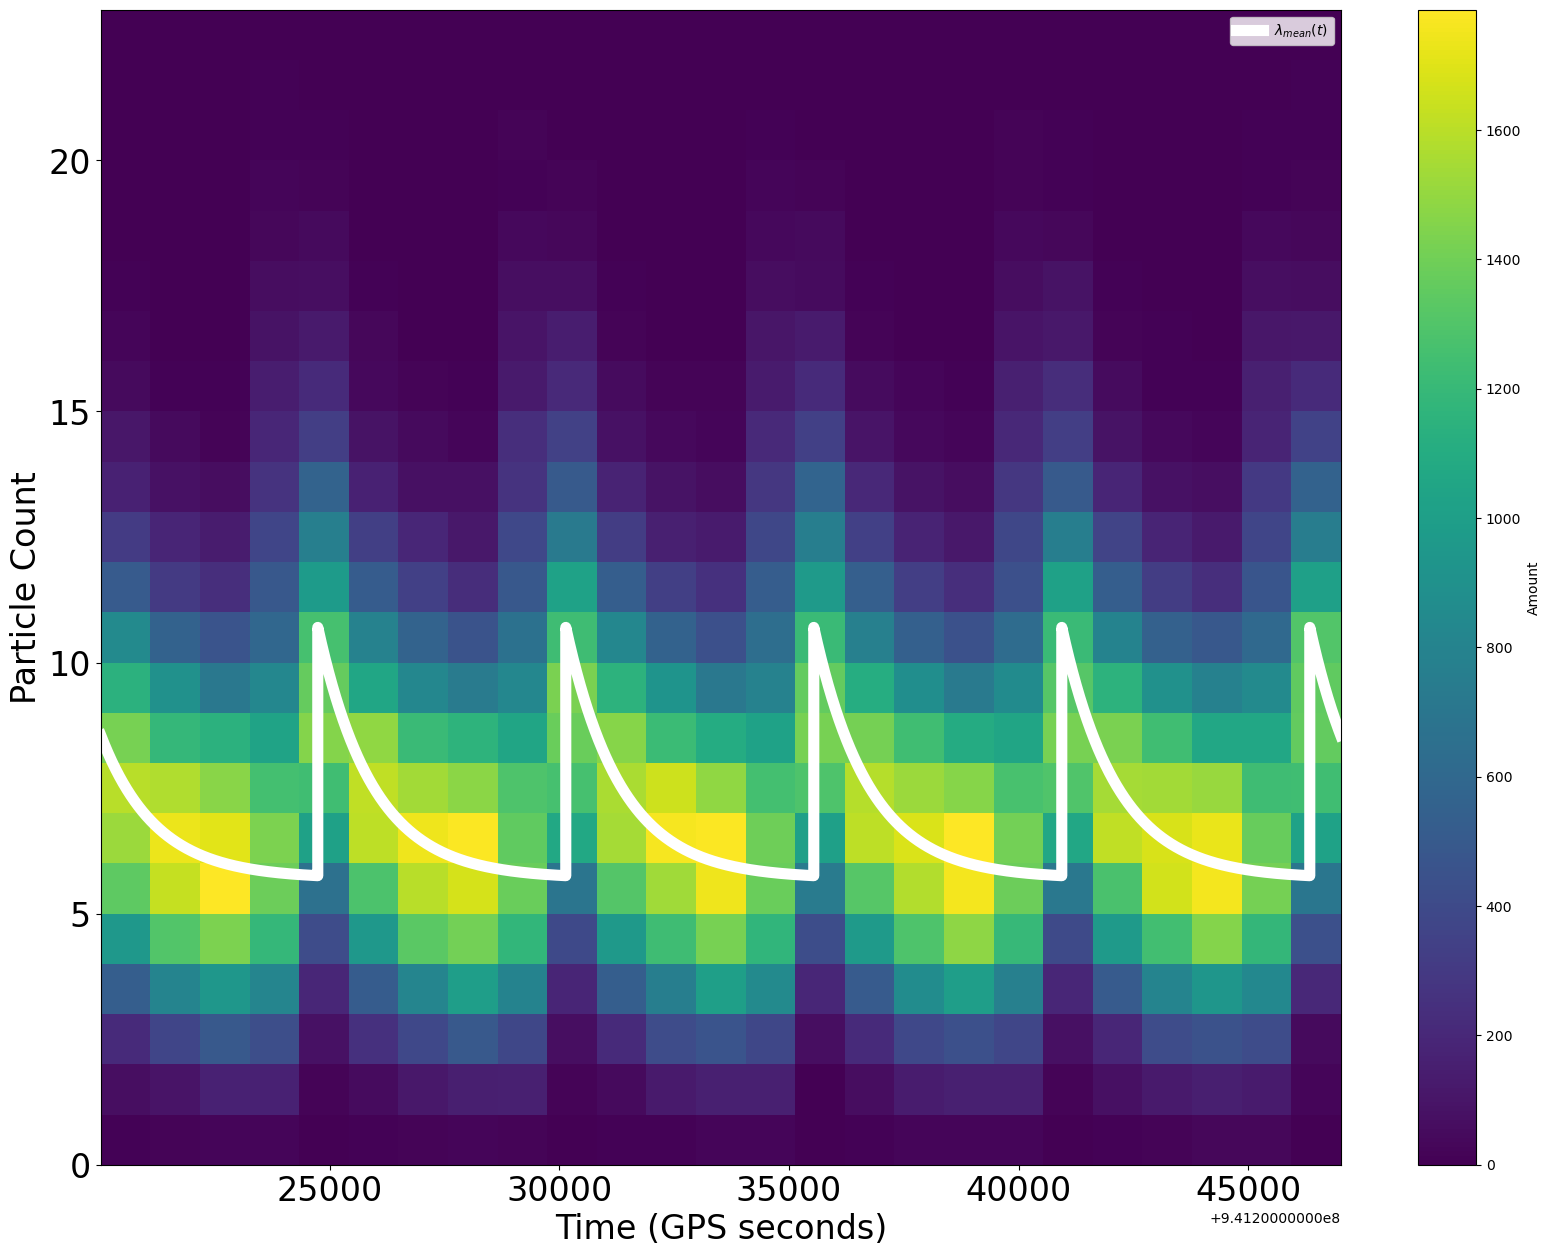

In [82]:
times_pdf_1, particle_counts_pdf_1 = get_subset(times, metadata, num_particles_idx, 100*orbit_period, 5*orbit_period)

cosmic_means = cosmic_pdf_lambda(times_pdf_1)

fig, ax = plt.subplots(1, 1)

hh = ax.hist2d(times_pdf_1, particle_counts_pdf_1, bins=25)
plt.plot(times_pdf_1, cosmic_means, linewidth=8, color='w', label='$\lambda_{mean}(t)$')
plt.tick_params(labelsize=24)
plt.ylim(0, 23)
plt.xlabel('Time (GPS seconds)', fontsize=24)
plt.ylabel('Particle Count', fontsize=24)
plt.legend()

fig.colorbar(hh[3], ax=ax, label='Amount')

### Part 3

TODO: Provide a qualitiative evaluation of now good the model is for the background

### Part 4

TODO: Choose 3 different times - calculate $\lambda$ for that time.  Determine a 5-sigma event for the three resulting distributions.  Only pose one statistical question

In [99]:
hf.close()

## Problem 2

Now lets look at a stack of telescope images.  Within these images we will be looking for the faintest stars.

### Part 1

First lets download and load the data into our notebook:

In [90]:
# first lets load our data
hf = h5py.File('images.h5', 'r')
image1 = np.array(hf.get('image1'))
imagestack = np.array(hf.get('imagestack'))

In [98]:
imagestack[0,0,0]

-0.5049209253540916

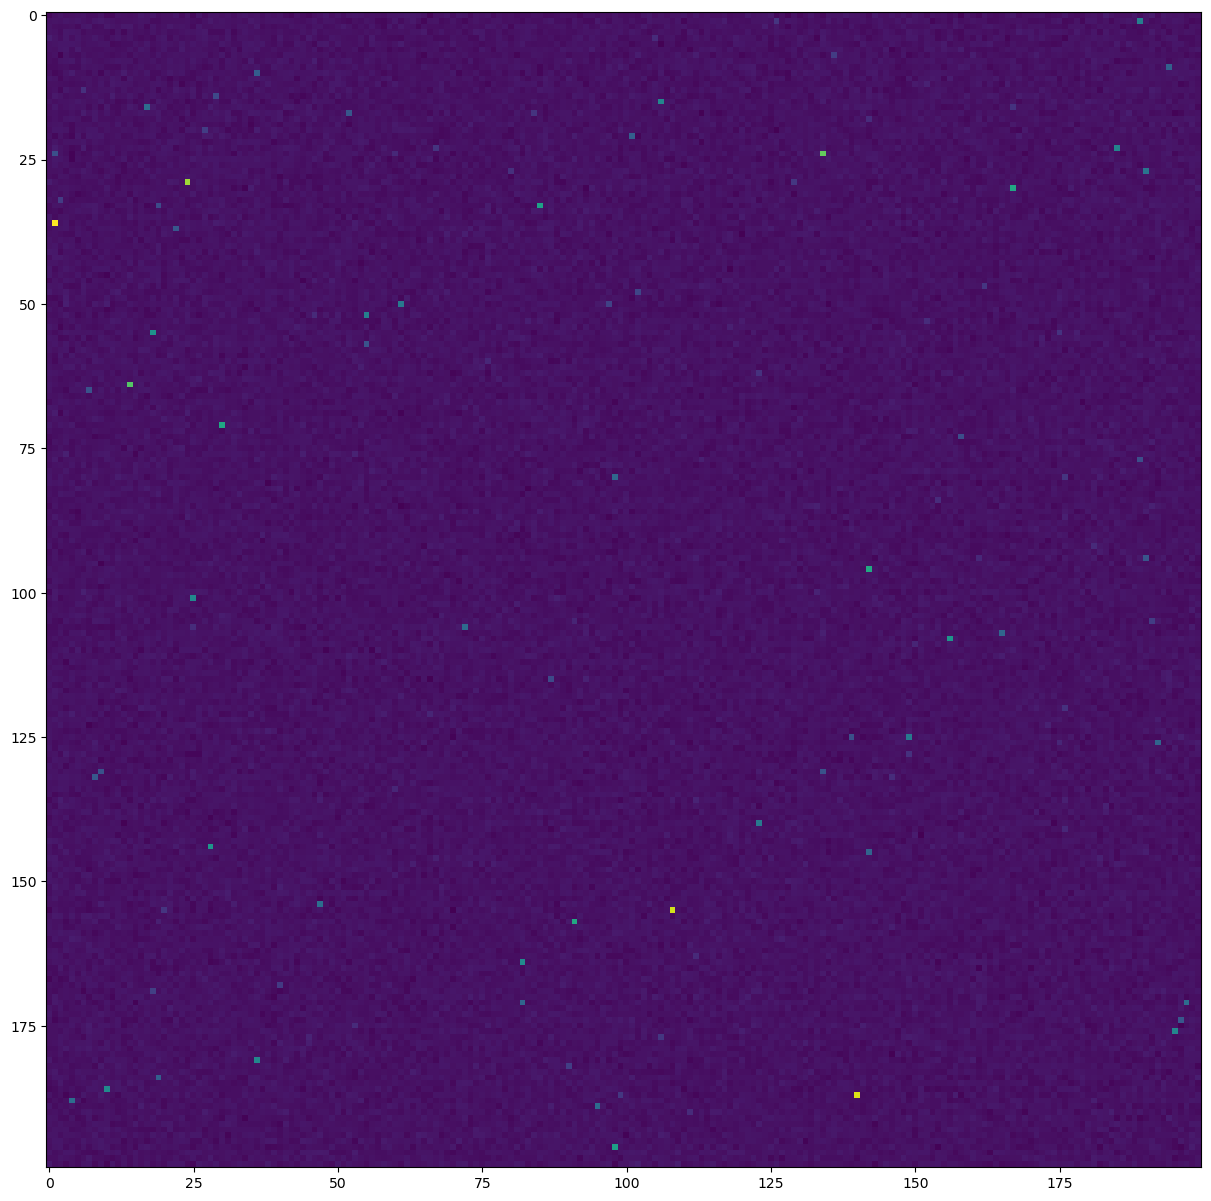

In [94]:
plt.rcParams["figure.figsize"] = (20,15)



plt.imshow(image1)
plt.show()

In [93]:
imagestack.shape

(200, 200, 10)

In [95]:
imagestack[:,:,5].shape

(200, 200)

In [ ]:
one pixel = star intensity + noise + transient

there is no contamination

the background will not be time depednent because the stars have constant 

determine the distribution of the background (should find that it is a gaussian.)

find the new distribution to answer desired question (I want to average the 10 images) - once you have the average distribution loop over all of the pixels in the average image and look for number of pixels that are above a 5-sigma event then subtract from this value the number of pixels in a single image that are above a 5-sigma event for the standard background distribution.  This result of count2 - count1 is the number of faint stars

We get different distributions because we are asking different questions


In [ ]:
hf.close()